In [89]:
!pip install shap tensorflow

<div style="border-radius:10px; padding: 15px; font-size:120%; text-align:left">
      
<h2 align="left"><font color=green>Flight Data Analysis</font></h2>

   
<br>

##**Exploratory Data Analysis:**
  - Which airlines has highest and lowest number of delayed flights?
  - What is the impact of diffrent delay types on total delay time?
  - Which airlines has the most cancelled and diverted flights?
  - How monthy and yearly delay distributions look like?

##**Predictive Analytics:**
  - Can we predict the flight delay level  (on time, small delay, large delay)  given, month, airport, airline names?

- Can we predict the number of delayed flights given month, airport, airline names?

- Can we predict the number of delayed flights for the next month (time series)?

## Exploratory Data Analysis

In [90]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedKFold
from imblearn.pipeline import Pipeline
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from imblearn.metrics import sensitivity_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

import matplotlib.pyplot as plt
from math import sqrt
import datetime as dt
import pandas as pd
import sklearn.tree
import seaborn as sns
import numpy as np
import shap

### Load Data

In [91]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [92]:
df = pd.read_csv('/content/gdrive/MyDrive/DS_airline_delay_causes.csv', encoding="ISO-8859-1")
df.drop(columns= 'Unnamed: 21', inplace=True)
df.head(8)

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2009,11,AS,Alaska Airlines Inc.,DCA,"Washington, DC: Ronald Reagan Washington National",88.0,11.0,1.99,0.00,...,0.0,0.00,0.0,0.0,266.0,65.0,0.0,201.0,0.0,0.0
1,2009,11,AS,Alaska Airlines Inc.,DEN,"Denver, CO: Denver International",123.0,5.0,3.47,0.00,...,0.0,0.00,0.0,0.0,81.0,57.0,0.0,24.0,0.0,0.0
2,2009,11,AS,Alaska Airlines Inc.,DFW,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...",66.0,6.0,1.28,0.69,...,0.0,0.00,0.0,0.0,176.0,64.0,11.0,101.0,0.0,0.0
3,2009,11,AS,Alaska Airlines Inc.,EWR,"Newark, NJ: Newark Liberty International",59.0,10.0,0.24,0.00,...,0.0,0.56,0.0,0.0,553.0,8.0,0.0,526.0,0.0,19.0
4,2009,11,AS,Alaska Airlines Inc.,HNL,"Honolulu, HI: Daniel K Inouye International",85.0,18.0,1.34,1.46,...,0.0,0.00,0.0,0.0,547.0,85.0,89.0,373.0,0.0,0.0
5,2009,11,AS,Alaska Airlines Inc.,IAH,"Houston, TX: George Bush Intercontinental/Houston",30.0,0.0,0.00,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2009,11,AS,Alaska Airlines Inc.,LAS,"Las Vegas, NV: McCarran International",283.0,20.0,10.39,0.00,...,0.0,5.16,0.0,0.0,978.0,721.0,0.0,113.0,0.0,144.0
7,2009,11,AS,Alaska Airlines Inc.,LAX,"Los Angeles, CA: Los Angeles International",469.0,37.0,11.64,0.00,...,1.0,0.95,0.0,0.0,1099.0,450.0,0.0,542.0,35.0,72.0


In [93]:
df.shape

(73282, 21)

In [94]:
df.nunique()

year                      18
 month                    12
carrier                   28
carrier_name              32
airport                   30
airport_name              30
arr_flights             7011
arr_del15               2287
carrier_ct             16079
 weather_ct             5242
nas_ct                 19812
security_ct             1033
late_aircraft_ct       18450
arr_cancelled            636
arr_diverted             137
 arr_delay             24227
 carrier_delay         12898
weather_delay           5001
nas_delay              13540
security_delay           596
late_aircraft_delay    15383
dtype: int64

In [95]:
df= df.rename({' month': 'month', ' arr_delay': 'arr_delay', ' weather_ct': 'weather_ct', ' carrier_delay': 'carrier_delay',}, axis=1)

In [96]:
for cl in [ 'carrier', 'carrier_name', 'airport', 'airport_name']:
    df[cl] = df[cl].astype(str)

for cl in ['month','year' ]:
    df[cl] = df[cl].astype(int)

numeric_columns=  ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
       'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

for cl in numeric_columns:
    df[cl] = df[cl].astype(float)

##  Check Missing Values

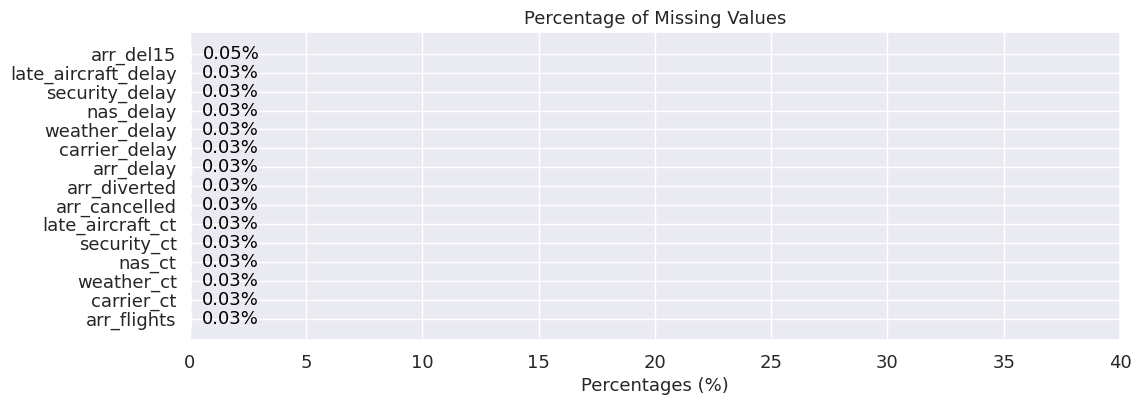

In [97]:
import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(16, 7)})

missing_data = df.isnull().sum()
fig, ax = plt.subplots(figsize=(12, 4))
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 50
missing_percentage.sort_values(ascending=True, inplace=True)
ax.barh(missing_percentage.index, missing_percentage, color='Purple')

for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontsize=13, color='black')

ax.set_xlim([0, 40])
ax.tick_params(axis='both',labelsize=13)
plt.title("Percentage of Missing Values", fontsize=13)
plt.xlabel('Percentages (%)', fontsize=13)
plt.show()

In [98]:
df= df.dropna()
missing_data = df.isnull().sum()    #df.fillna(df.mean(), inplace=True)
missing_data

year                   0
month                  0
carrier                0
carrier_name           0
airport                0
airport_name           0
arr_flights            0
arr_del15              0
carrier_ct             0
weather_ct             0
nas_ct                 0
security_ct            0
late_aircraft_ct       0
arr_cancelled          0
arr_diverted           0
arr_delay              0
carrier_delay          0
weather_delay          0
nas_delay              0
security_delay         0
late_aircraft_delay    0
dtype: int64

## Check Duplicates

In [99]:
duplicate_rows = df[df.duplicated(keep=False)]
duplicate_rows

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay


## Sanity Check

In [100]:
df['arr_flights'].describe()

count    73211.000000
mean       994.259606
std       1855.244965
min          1.000000
25%        124.000000
50%        331.000000
75%        867.000000
max      21977.000000
Name: arr_flights, dtype: float64

In [101]:
df['arr_delay'].describe()

count     73211.000000
mean      11339.752879
std       23124.803113
min           0.000000
25%        1218.000000
50%        3582.000000
75%        9932.000000
max      433687.000000
Name: arr_delay, dtype: float64

# Airline Analysis

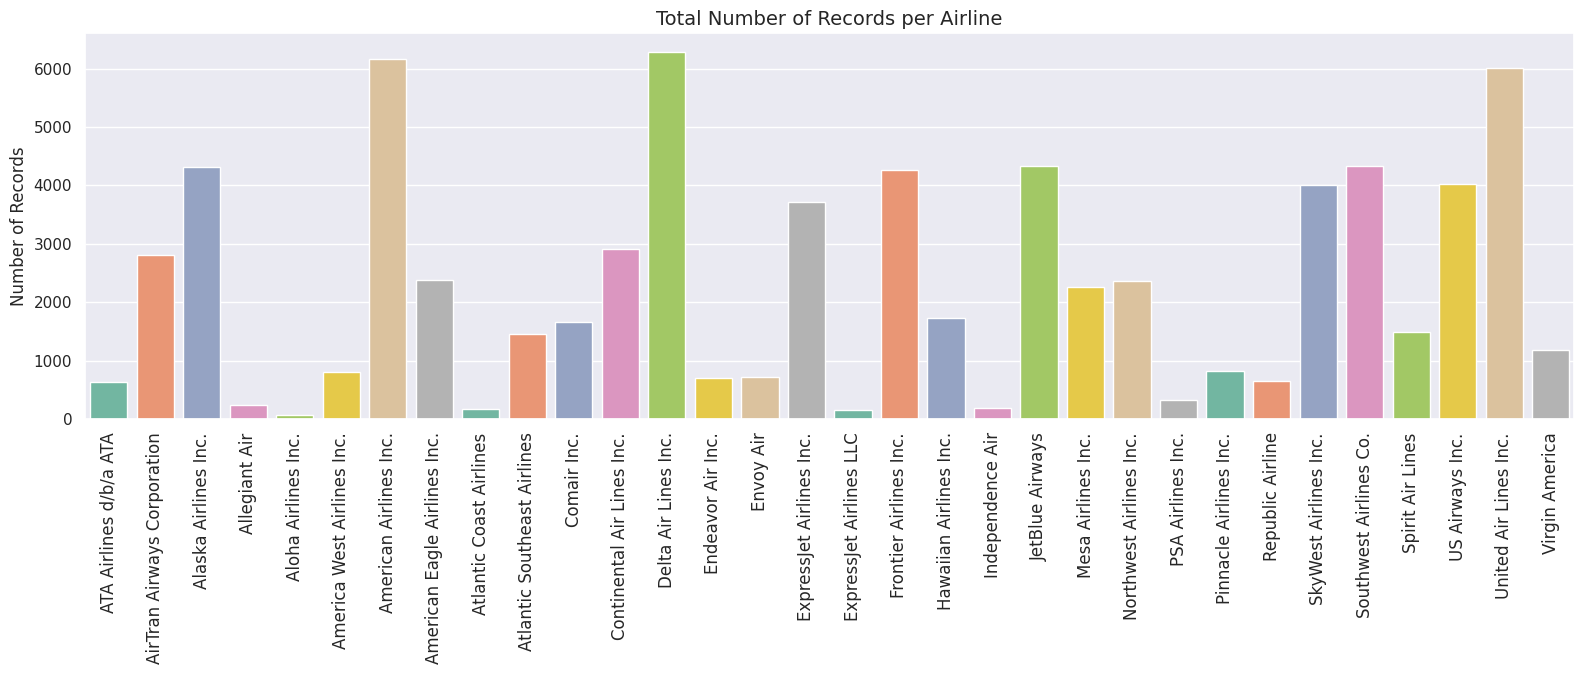

In [102]:
df_crr = df.groupby(['carrier_name'])['arr_flights'].count().reset_index(name='record_count')
sns.set(rc={'figure.figsize':(16, 7)})
sns.barplot(x='carrier_name', y='record_count', data=df_crr, palette='Set2')  #, hue='carrier_name'
plt.xlabel(' ', fontsize=2)
plt.ylabel('Number of Records', fontsize=12)
plt.title('Total Number of Records per Airline', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.show()

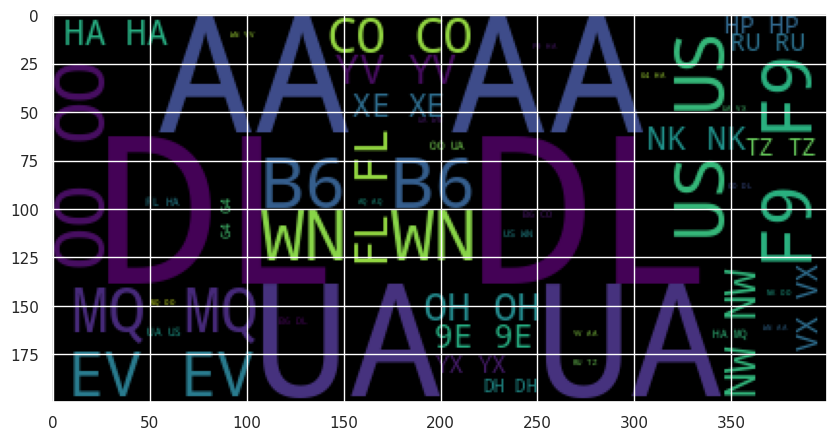

In [103]:
from wordcloud import WordCloud
fig, ax = plt.subplots(figsize=(10, 6))

wordcloud2 = WordCloud().generate(' '.join(df['carrier']))

plt.imshow(wordcloud2)
plt.show()

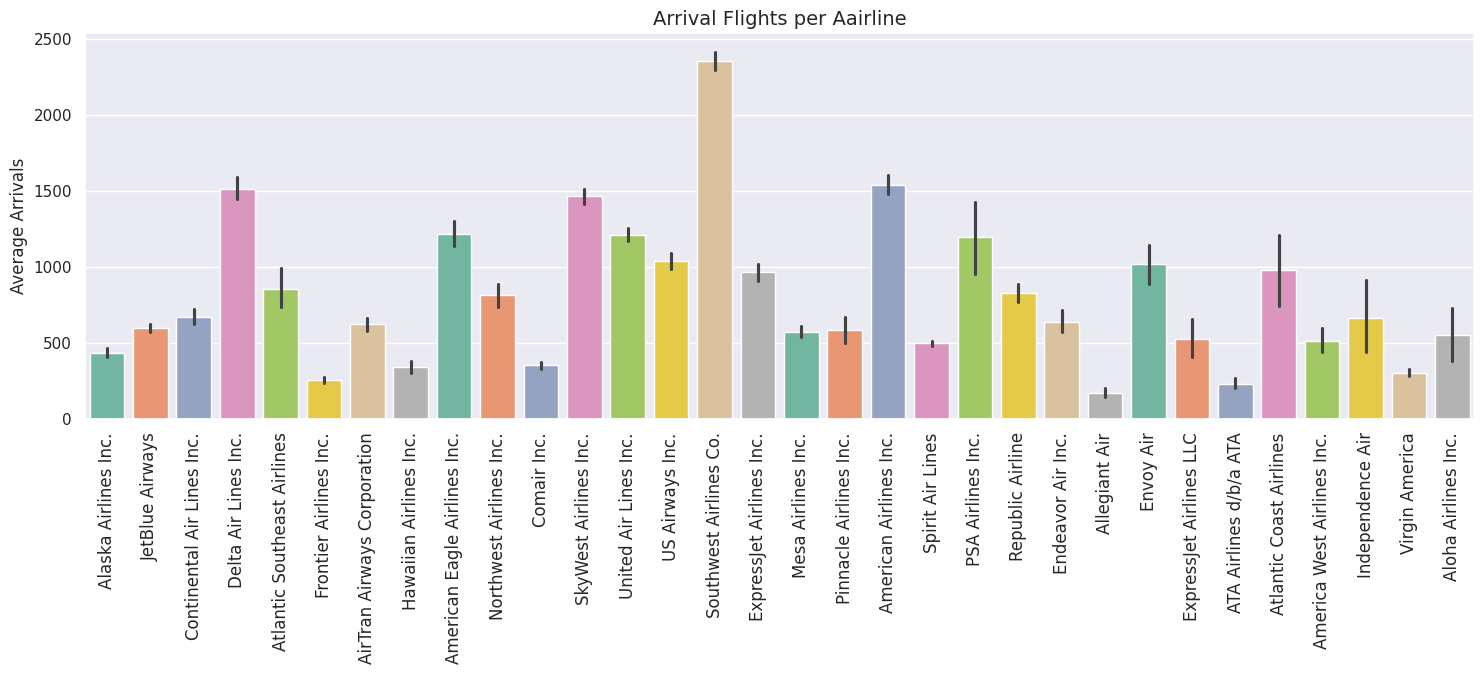

In [104]:
sns.set(rc={'figure.figsize':(15, 7)})
plt.figure(figsize=(15, 7))
sns.barplot(x='carrier_name', y='arr_flights', data=df, palette='Set2')
plt.xlabel(' ', fontsize=2)
plt.ylabel('Average Arrivals', fontsize=12)
plt.title('Arrival Flights per Aairline', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.show()

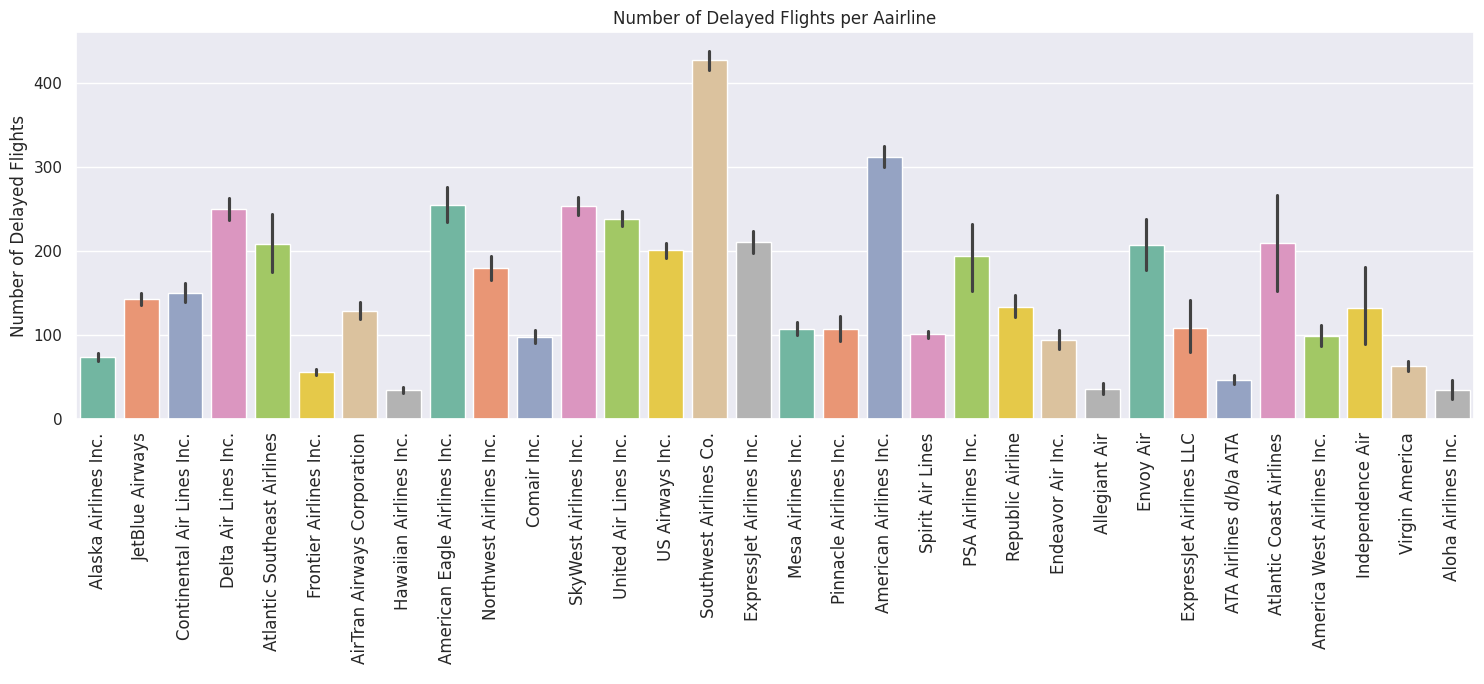

In [105]:
plt.figure(figsize=(15, 7))
sns.barplot(x='carrier_name', y='arr_del15', data=df, palette='Set2')
plt.xlabel(' ', fontsize=2)
plt.ylabel('Number of Delayed Flights', fontsize=12)
plt.title('Number of Delayed Flights per Aairline', fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.tight_layout()
plt.show()

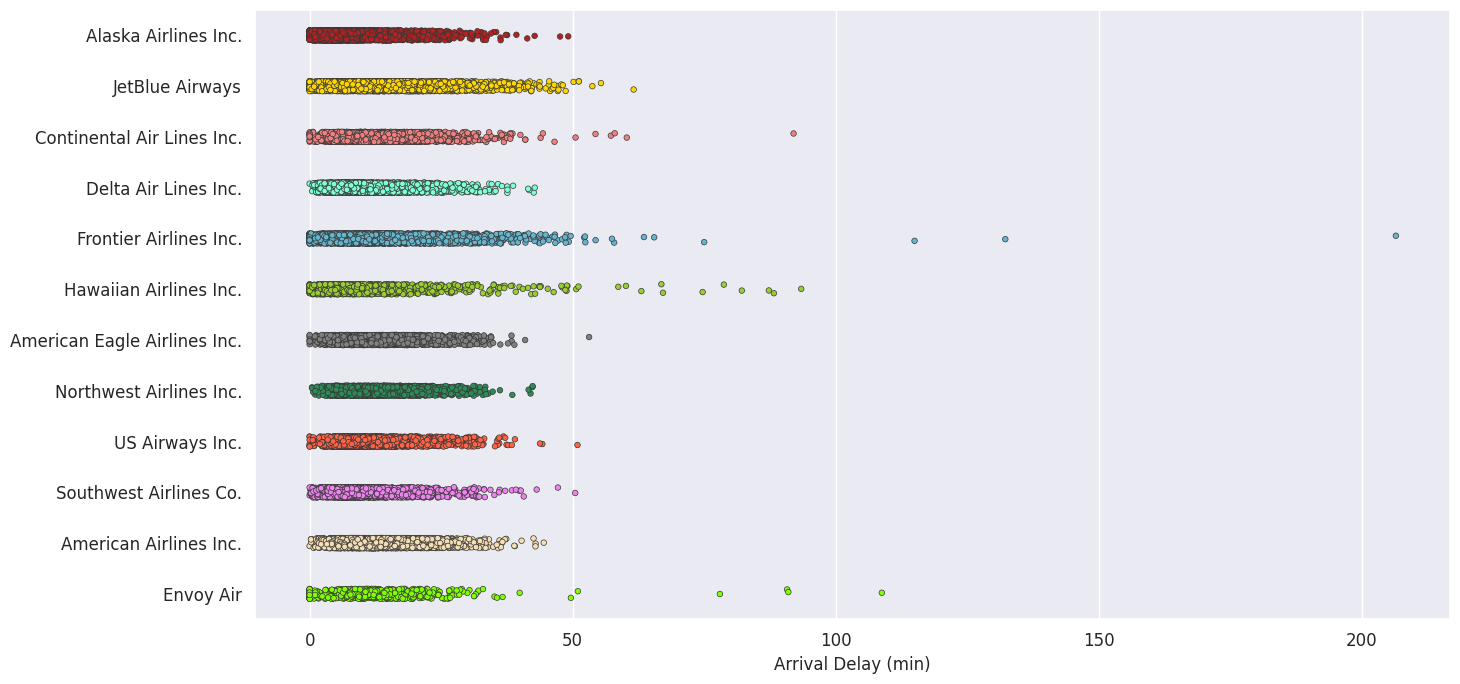

In [106]:
fig = plt.figure(1, figsize=(15,7))

colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']

colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']

df_new=df.copy()

df_new= df_new[ (df_new["carrier_name"]== 'Alaska Airlines Inc.') |  (df_new["carrier_name"]== 'JetBlue Airways')| (df_new["carrier_name"]== 'American Airlines Inc.')|
      (df_new["carrier_name"]== 'Delta Air Lines Inc.')| (df_new["carrier_name"]== 'Hawaiian Airlines Inc.')| (df_new["carrier_name"]== 'Northwest Airlines Inc.')|
      (df_new["carrier_name"]== 'Frontier Airlines Inc.') | (df_new["carrier_name"]== 'American Eagle Airlines Inc.')| (df_new["carrier_name"]== 'Continental Air Lines Inc.')|
      (df_new["carrier_name"]== 'Envoy Air') | (df_new["carrier_name"]== 'US Airways Inc.')| (df_new["carrier_name"]== 'Southwest Airlines Co.')]

df_new['arr_average_delay']= df_new['arr_delay']/df_new['arr_flights']

ax3 = sns.stripplot(data=df_new, y="carrier_name", x="arr_average_delay", size = 4, palette = colors,    linewidth = 0.5,  jitter=True)

plt.setp(ax3.get_xticklabels(), fontsize=12)
plt.setp(ax3.get_yticklabels(), fontsize=12)
plt.xlabel('Arrival Delay (min)', fontsize=12)
plt.tight_layout()

ax3.yaxis.label.set_visible(False)


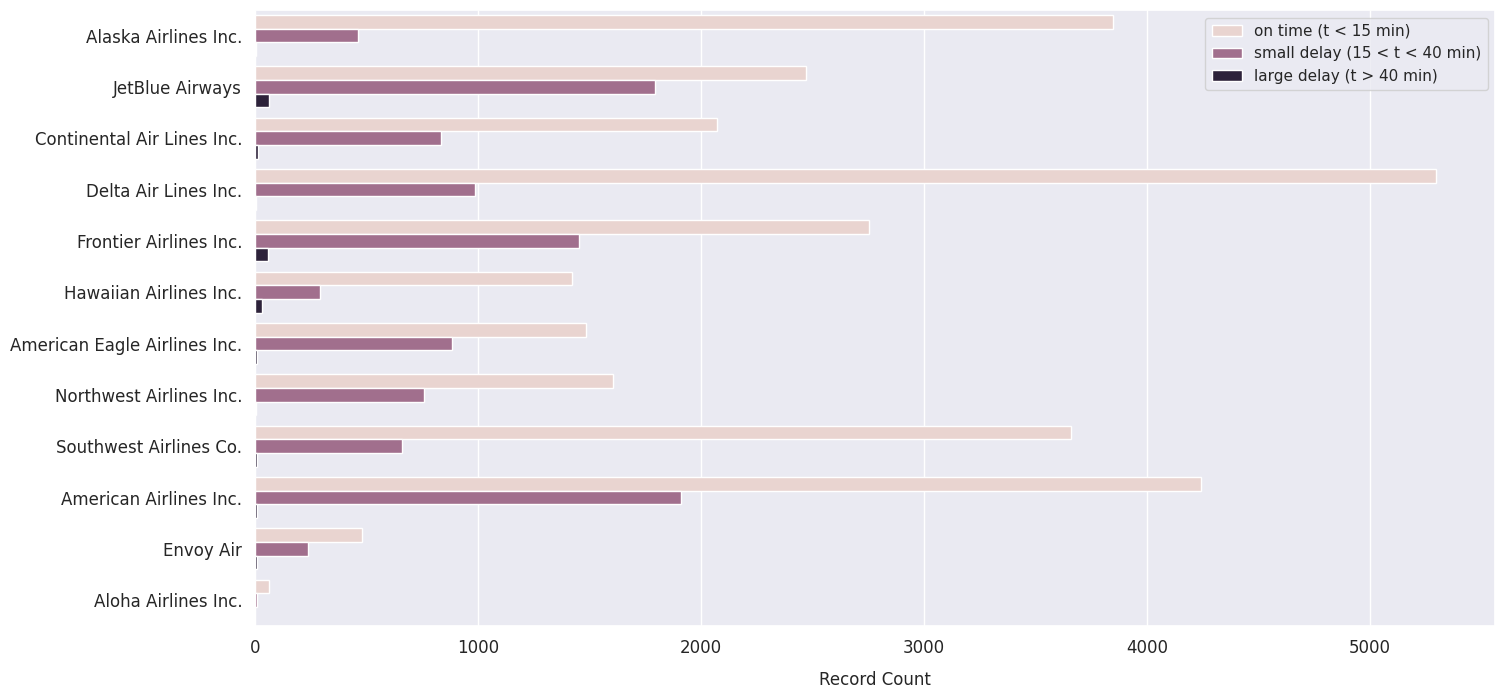

In [107]:
df_delay= df.copy()
df_delay['sum_cancel_diverted']= df_delay['arr_cancelled'] + df_delay['arr_diverted']
df_delay['correct_arr_flights']= df_delay['arr_flights']- df_delay['sum_cancel_diverted']
df_delay['avg_delay_per_flight'] = df_delay['arr_delay'] / df_delay['correct_arr_flights']

delay_type = lambda x:((0,1)[x > 15],2)[x >= 40]
df_delay['delay_level'] = df_delay['avg_delay_per_flight'].apply(delay_type)

df_new= df_delay.copy()
df_new= df_new[ (df_new["carrier_name"]== 'Alaska Airlines Inc.') |  (df_new["carrier_name"]== 'JetBlue Airways')| (df_new["carrier_name"]== 'American Airlines Inc.')|
      (df_new["carrier_name"]== 'Delta Air Lines Inc.')| (df_new["carrier_name"]== 'Hawaiian Airlines Inc.')| (df_new["carrier_name"]== 'Northwest Airlines Inc.')|
      (df_new["carrier_name"]== 'Frontier Airlines Inc.') | (df_new["carrier_name"]== 'American Eagle Airlines Inc.')| (df_new["carrier_name"]== 'Continental Air Lines Inc.')|
      (df_new["carrier_name"]== 'Envoy Air') | (df_new["carrier_name"]== 'Aloha Airlines Inc.')| (df_new["carrier_name"]== 'Southwest Airlines Co.')]


fig = plt.figure(1, figsize=(16,8))
ax = sns.countplot(data=df_new, y="carrier_name", hue='delay_level')
plt.setp(ax.get_xticklabels(), fontsize=12, rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Record Count', fontsize=12, labelpad=10)

L = plt.legend()
L.get_texts()[0].set_text('on time (t < 15 min)')
L.get_texts()[1].set_text('small delay (15 < t < 40 min)')
L.get_texts()[2].set_text('large delay (t > 40 min)')
plt.show()

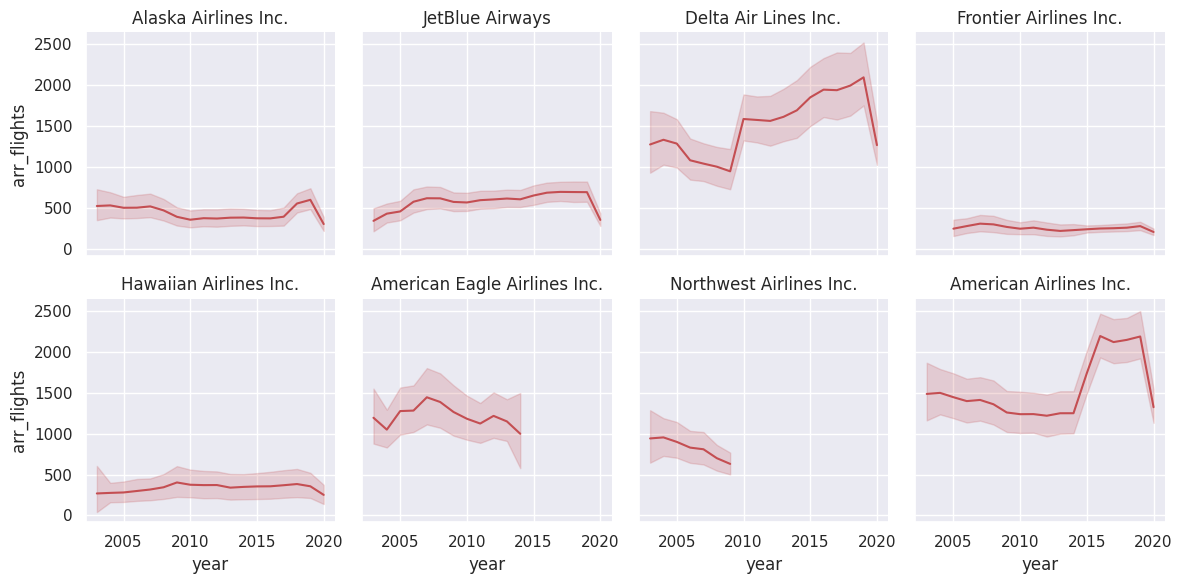

In [108]:
df_vs=df.copy()

df_vs= df_vs[ (df_vs["carrier_name"]== 'Alaska Airlines Inc.') |  (df_vs["carrier_name"]== 'JetBlue Airways')| (df_vs["carrier_name"]== 'American Airlines Inc.')|
      (df_vs["carrier_name"]== 'Delta Air Lines Inc.')| (df_vs["carrier_name"]== 'Hawaiian Airlines Inc.')| (df_vs["carrier_name"]== 'Northwest Airlines Inc.')|
                (df_vs["carrier_name"]== 'Frontier Airlines Inc.') | (df_vs["carrier_name"]== 'American Eagle Airlines Inc.')]

sns.set(rc={'figure.figsize':(17, 7)})
g = sns.FacetGrid(df_vs, col="carrier_name",col_wrap=4)
g.map_dataframe(sns.lineplot,"year","arr_flights", data=df_vs,color='r')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.show()

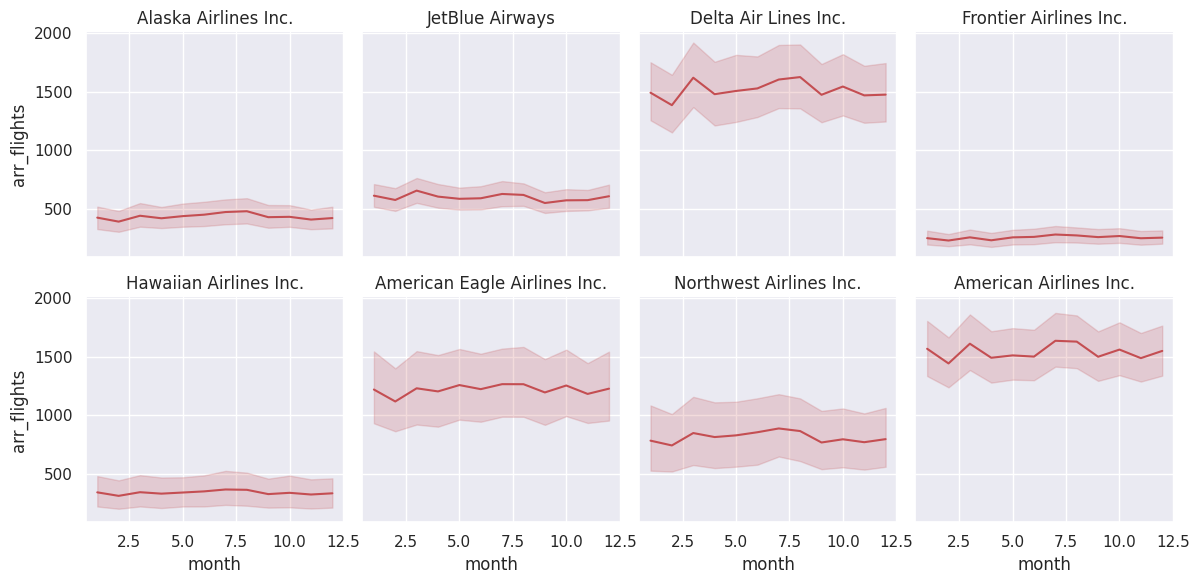

In [109]:
sns.set(rc={'figure.figsize':(17, 7)})
g = sns.FacetGrid(df_vs, col="carrier_name",col_wrap=4)
g.map_dataframe(sns.lineplot,"month","arr_flights", data=df_vs,color='r')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.show()

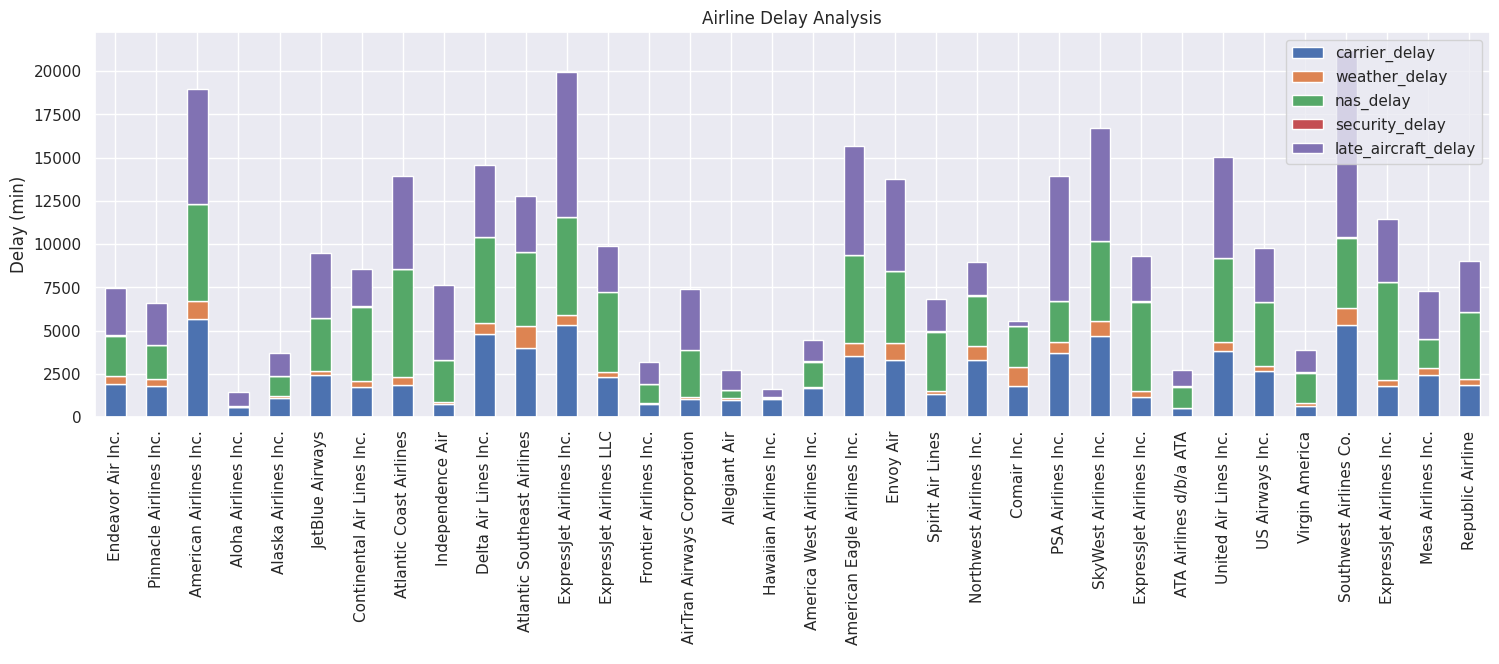

In [110]:
cols = ['carrier', 'carrier_name', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
df_viss = df[cols]

carrier_performance = df_viss.groupby(['carrier', 'carrier_name']).mean().reset_index()
carrier_performance.plot(x='carrier_name', kind='bar', stacked=True, figsize=(18,5))
plt.xlabel('  ', fontsize= 3)
plt.ylabel('Delay (min)')
plt.title('Airline Delay Analysis')
plt.legend(loc='upper right')
plt.show()

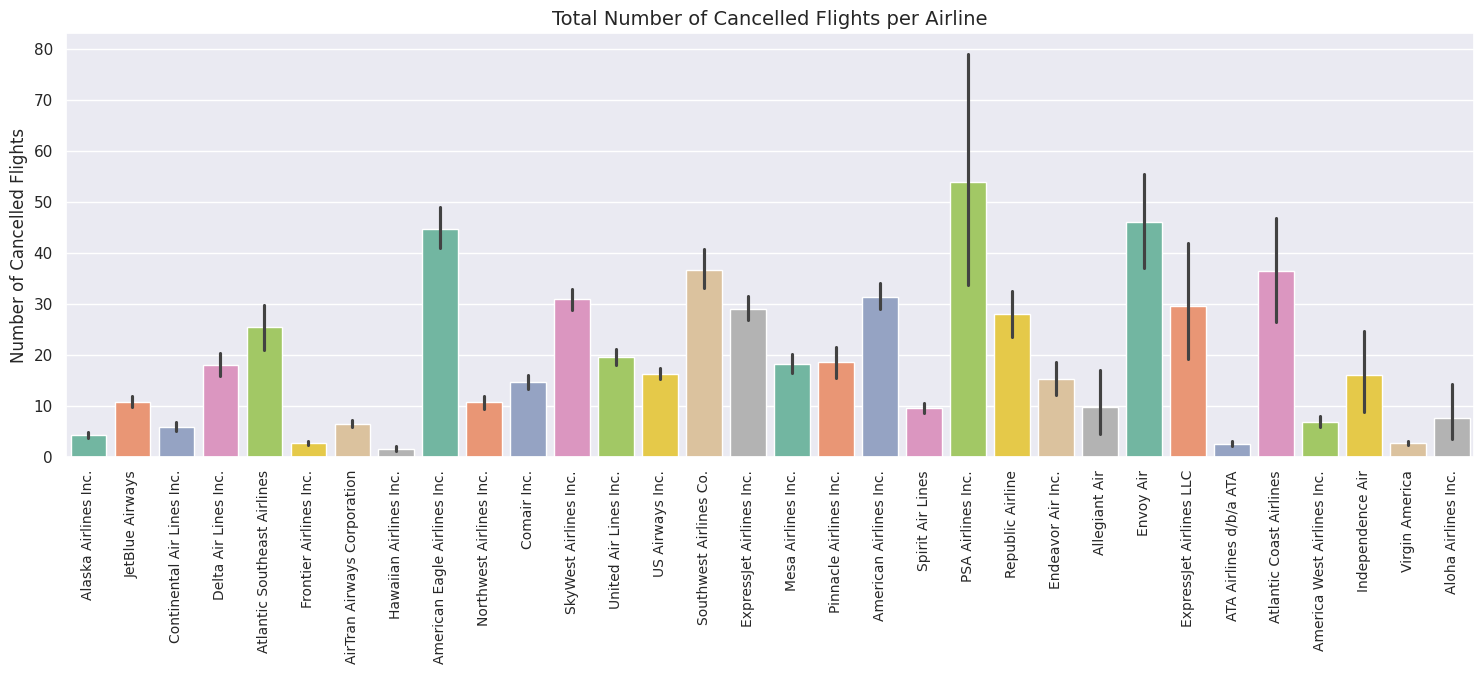

In [111]:
plt.figure(figsize=(15, 7))
sns.barplot(x='carrier_name', y='arr_cancelled', data=df, palette='Set2')
plt.xlabel(' ', fontsize=2)
plt.ylabel('Number of Cancelled Flights', fontsize=12)
plt.title('Total Number of Cancelled Flights per Airline', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

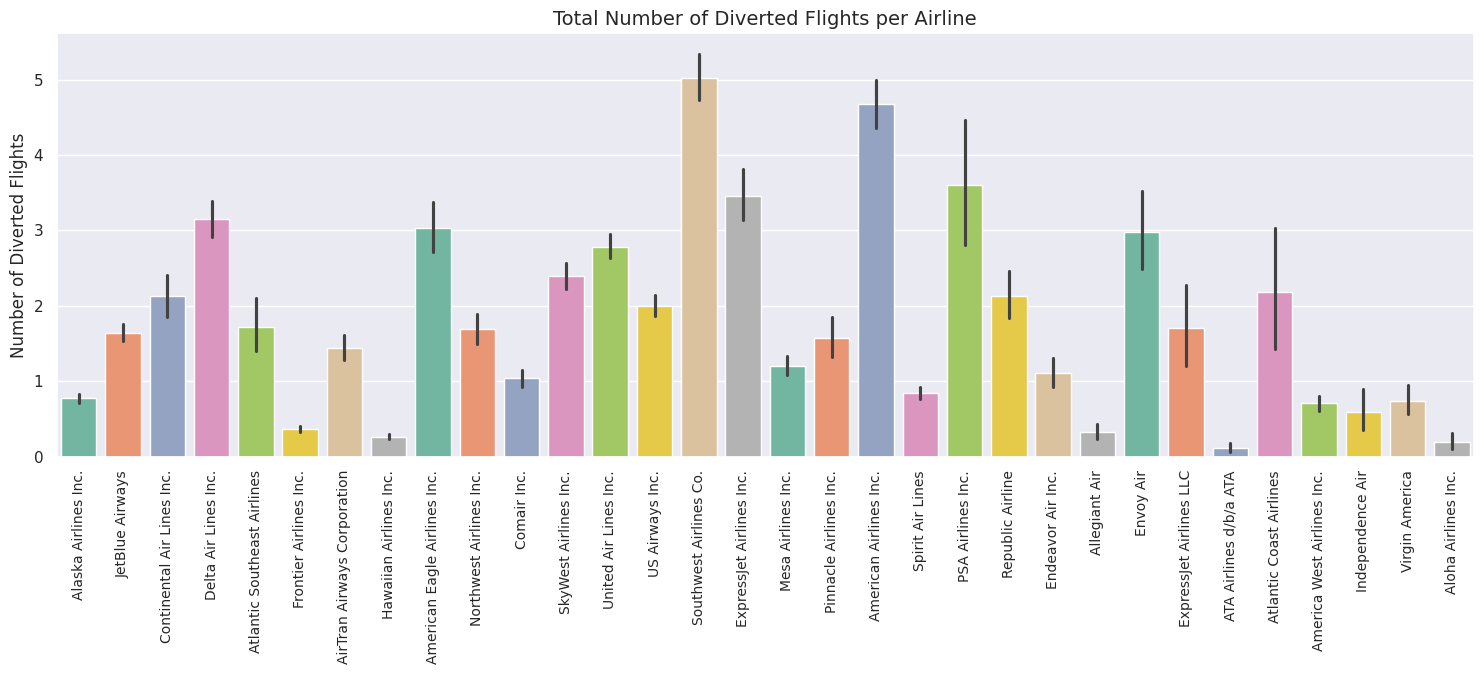

In [112]:
plt.figure(figsize=(15, 7))
sns.barplot(x='carrier_name', y='arr_diverted', data=df, palette='Set2')
plt.xlabel(' ', fontsize=2)
plt.ylabel('Number of Diverted Flights', fontsize=12)
plt.title('Total Number of Diverted Flights per Airline', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

# **Airport Analysis**

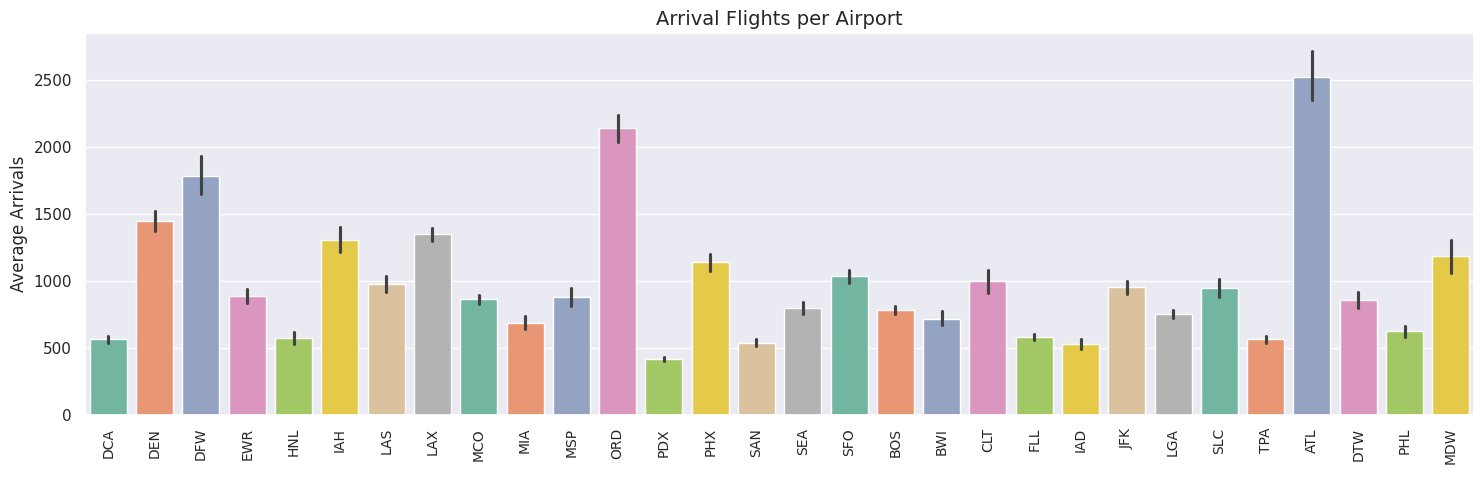

In [113]:
plt.figure(figsize=(15, 5))
sns.barplot(x='airport', y='arr_flights', data=df, palette='Set2')
plt.xlabel(' ', fontsize=2)
plt.ylabel('Average Arrivals', fontsize=12)
plt.title('Arrival Flights per Airport', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

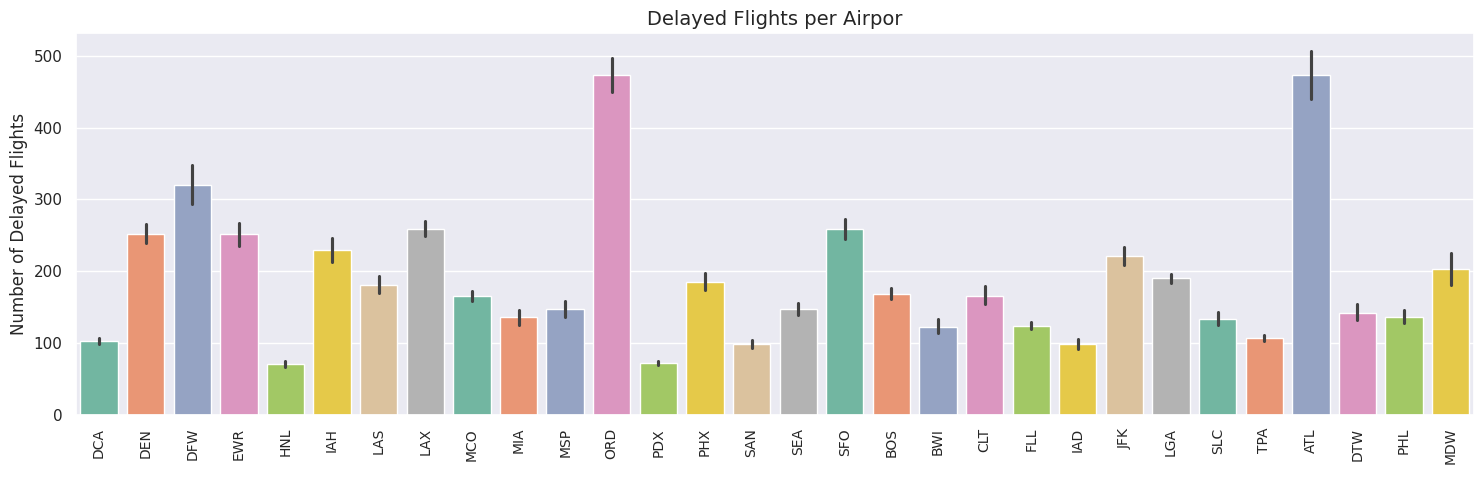

In [114]:
plt.figure(figsize=(15, 5))
sns.barplot(x='airport', y='arr_del15', data=df, palette='Set2')
plt.xlabel(' ', fontsize=2)
plt.ylabel('Number of Delayed Flights', fontsize=12)
plt.title('Delayed Flights per Airpor', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

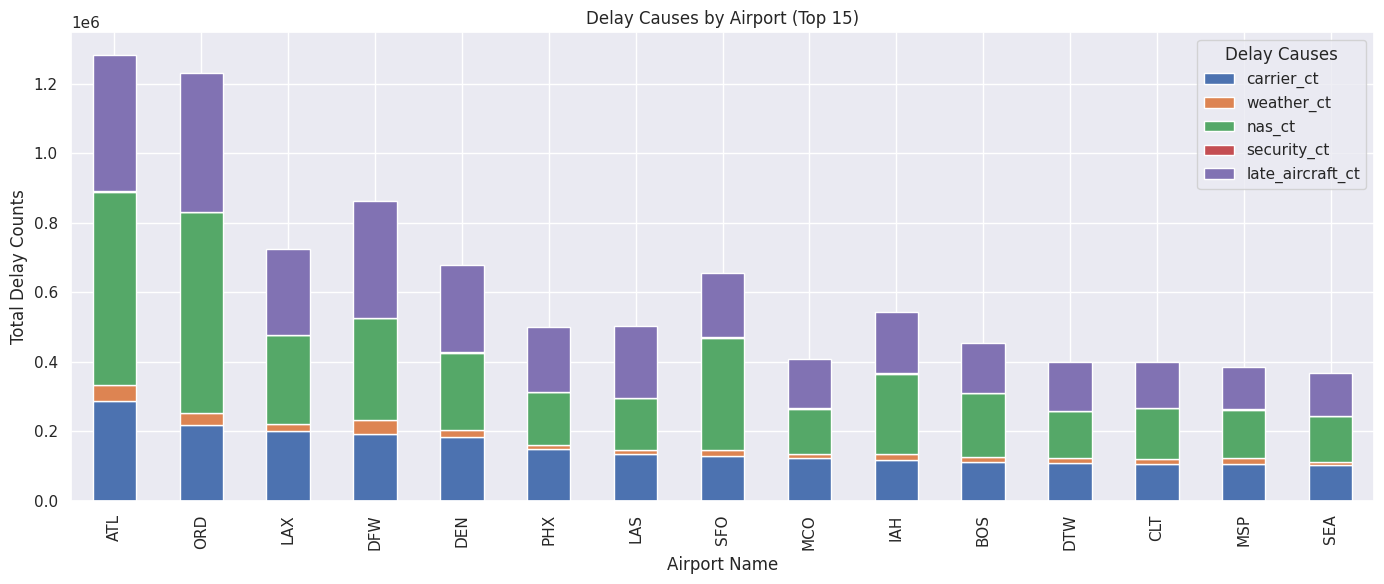

In [115]:
delay_cause_data = df[['airport', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']]
delay_cause_totals = delay_cause_data.groupby('airport').sum()
top_15_airports = delay_cause_totals.nlargest(15, 'carrier_ct')
top_15_airports.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Delay Causes by Airport (Top 15)')
plt.xlabel('Airport Name')
plt.ylabel('Total Delay Counts')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend(title='Delay Causes')
plt.show()

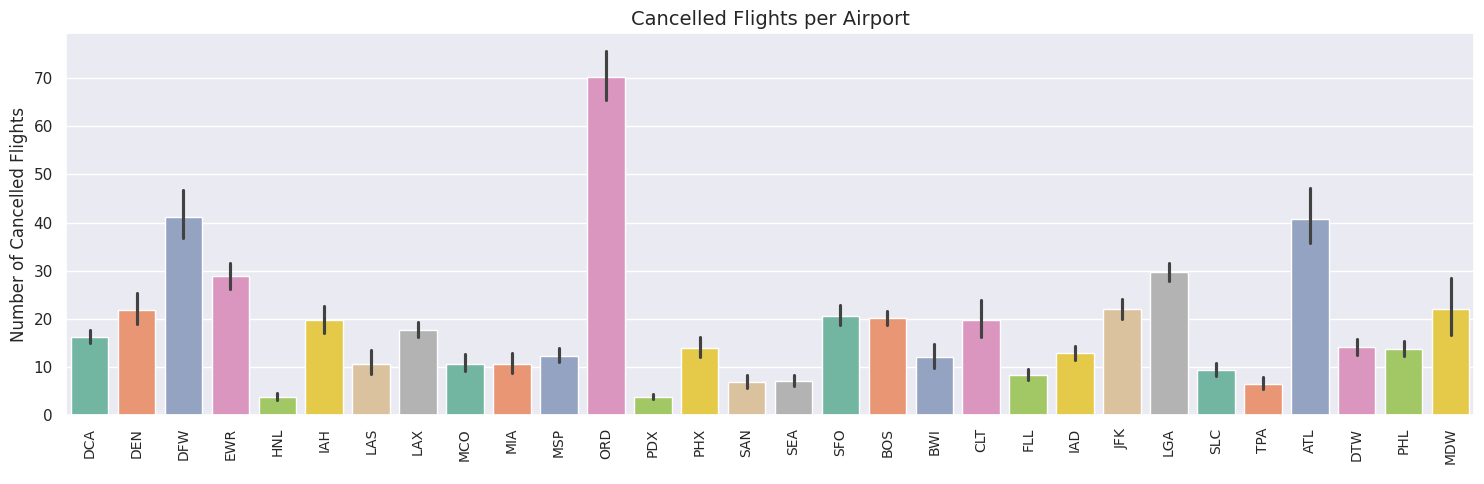

In [116]:
plt.figure(figsize=(15, 5))
sns.barplot(x='airport', y='arr_cancelled', data=df, palette='Set2')
plt.xlabel(' ', fontsize=2)
plt.ylabel('Number of Cancelled Flights', fontsize=12)
plt.title('Cancelled Flights per Airport', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

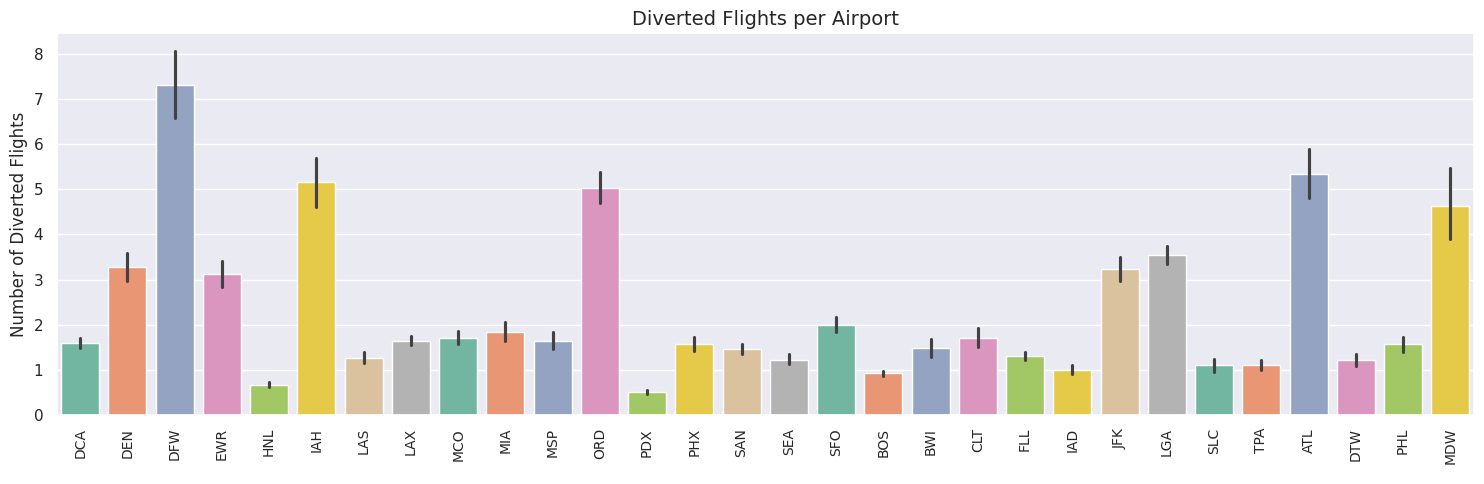

In [117]:
plt.figure(figsize=(15, 5))
sns.barplot(x='airport', y='arr_diverted', data=df, palette='Set2')
plt.xlabel(' ', fontsize=2)
plt.ylabel('Number of Diverted Flights', fontsize=12)
plt.title('Diverted Flights per Airport', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

# **Yearly and Monthly Analysis**

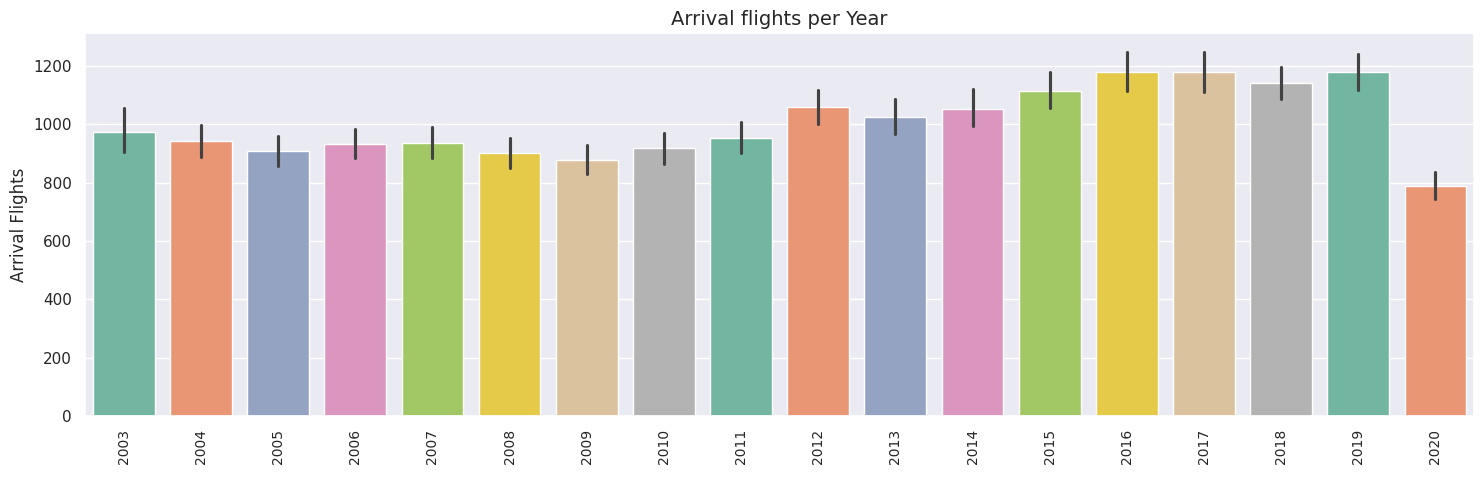

In [118]:
plt.figure(figsize=(15, 5))
sns.barplot(x='year', y='arr_flights', data=df, palette='Set2')
plt.xlabel(' ', fontsize=2)
plt.ylabel('Arrival Flights', fontsize=12)
plt.title('Arrival flights per Year', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

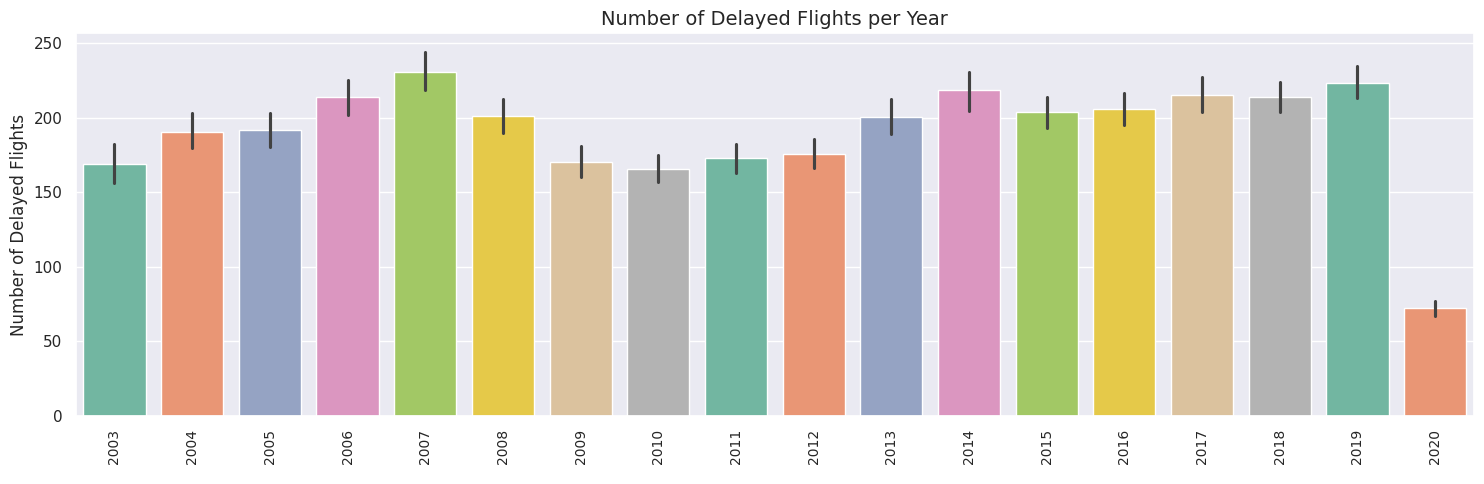

In [119]:
plt.figure(figsize=(15, 5))
sns.barplot(x='year', y='arr_del15', data=df, palette='Set2')
plt.xlabel(' ', fontsize=2)
plt.ylabel('Number of Delayed Flights', fontsize=12)
plt.title('Number of Delayed Flights per Year', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

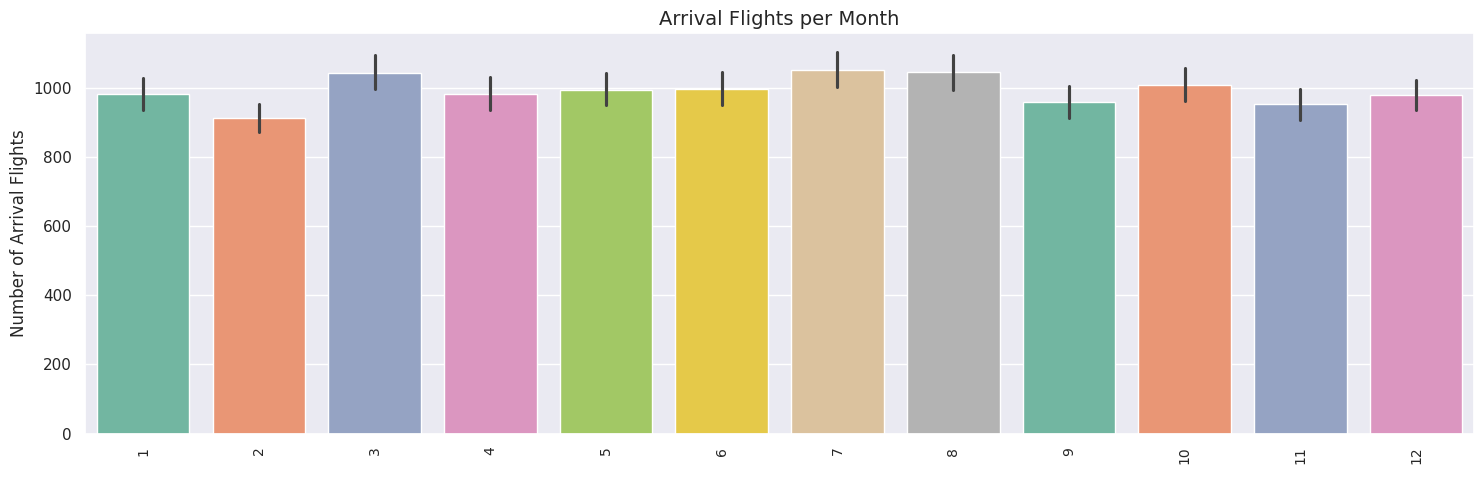

In [120]:
plt.figure(figsize=(15, 5))
sns.barplot(x='month', y='arr_flights', data=df, palette='Set2')
plt.xlabel(' ', fontsize=2)
plt.ylabel('Number of Arrival Flights', fontsize=12)
plt.title('Arrival Flights per Month', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

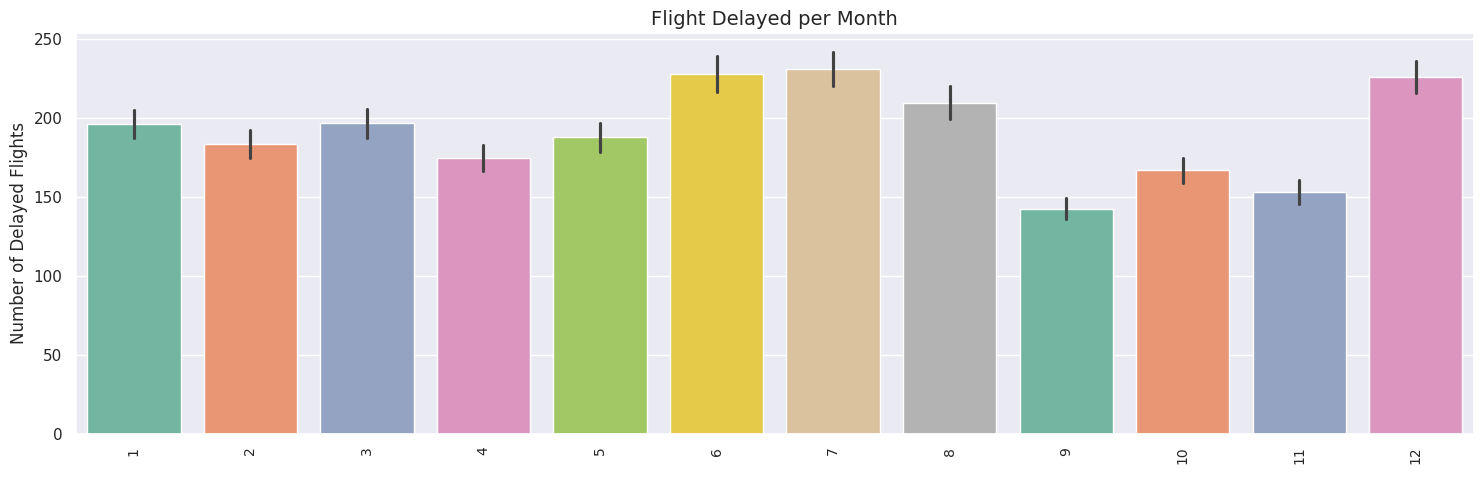

In [121]:
plt.figure(figsize=(15, 5))
sns.barplot(x='month', y='arr_del15', data=df, palette='Set2')
plt.xlabel(' ', fontsize=2)
plt.ylabel('Number of Delayed Flights', fontsize=12)
plt.title('Flight Delayed per Month', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

# **Distribution and Correlation Analysis**

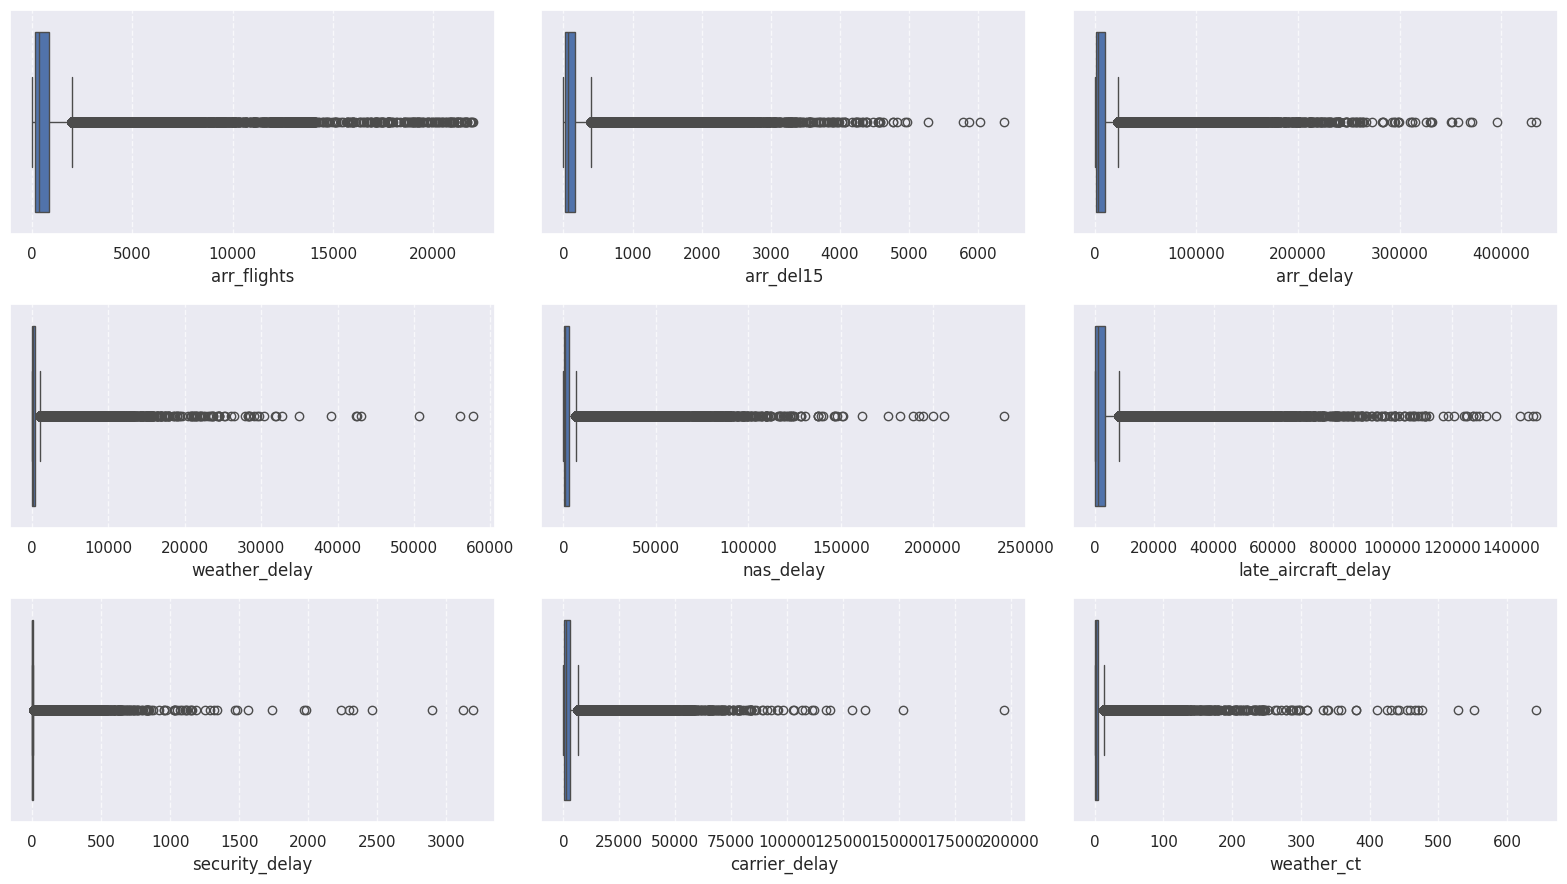

In [122]:
sns.set(font_scale=1.0)
sns.set(rc={'figure.figsize':(17, 7)})
fig, axes = plt.subplots(3, 3, figsize=(16, 9))

axes[0, 0].grid(True, linestyle='--', alpha=0.7)
axes[0, 1].grid(True, linestyle='--', alpha=0.7)
axes[0, 2].grid(True, linestyle='--', alpha=0.7)
axes[1, 0].grid(True, linestyle='--', alpha=0.7)
axes[1, 1].grid(True, linestyle='--', alpha=0.7)
axes[1, 2].grid(True, linestyle='--', alpha=0.7)
axes[2, 0].grid(True, linestyle='--', alpha=0.7)
axes[2, 1].grid(True, linestyle='--', alpha=0.7)
axes[2, 2].grid(True, linestyle='--', alpha=0.7)

sns.boxplot(ax=axes[0, 0], data=df, x='arr_flights', linewidth=1 ,saturation=0.9)
sns.boxplot(ax=axes[0, 1], data=df, x='arr_del15', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[0, 2], data=df, x='arr_delay', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[1, 0], data=df, x='weather_delay', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[1, 1], data=df, x='nas_delay', linewidth=1 ,saturation=0.9)
sns.boxplot(ax=axes[1, 2], data=df, x='late_aircraft_delay', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[2, 0], data=df, x='security_delay', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[2, 1], data=df, x='carrier_delay', linewidth=1,saturation=0.9)
sns.boxplot(ax=axes[2, 2], data=df, x='weather_ct', linewidth=1,saturation=0.9)

fig.tight_layout()
plt.show()

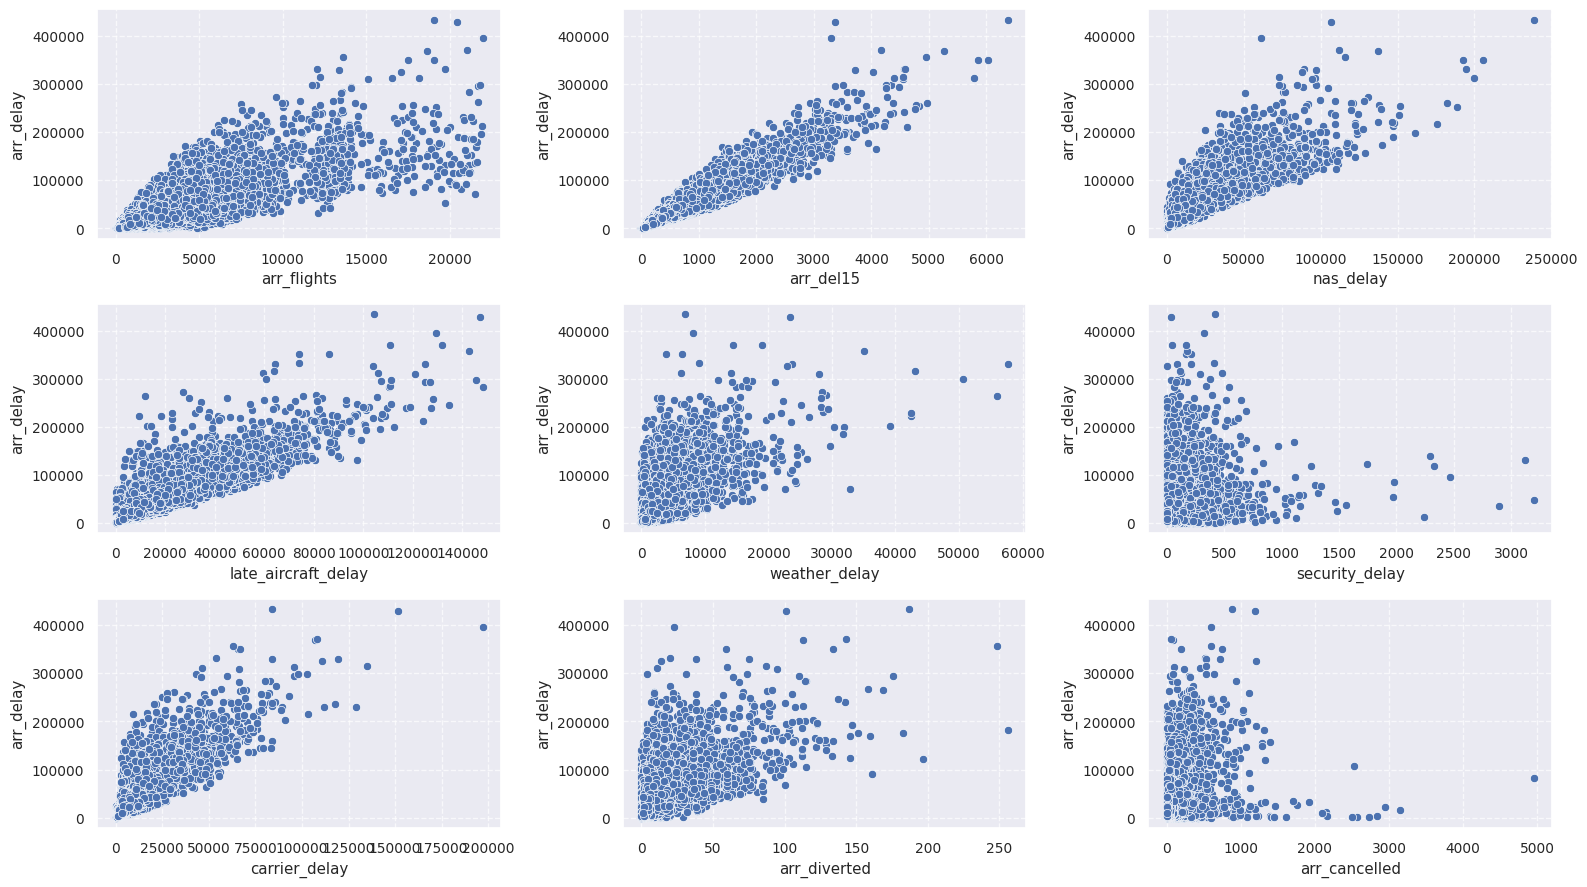

In [123]:
sns.set(font_scale=0.9)
fig, axes = plt.subplots(3, 3, figsize=(16, 9))
axes[0, 0].grid(True, linestyle='--', alpha=0.7)
axes[0, 1].grid(True, linestyle='--', alpha=0.7)
axes[0, 2].grid(True, linestyle='--', alpha=0.7)
axes[1, 0].grid(True, linestyle='--', alpha=0.7)
axes[1, 1].grid(True, linestyle='--', alpha=0.7)
axes[1, 2].grid(True, linestyle='--', alpha=0.7)
axes[2, 0].grid(True, linestyle='--', alpha=0.7)
axes[2, 1].grid(True, linestyle='--', alpha=0.7)
axes[2, 2].grid(True, linestyle='--', alpha=0.7)

sns.scatterplot( data=df, x=df['arr_flights'], y=df['arr_delay'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[0, 0])
sns.scatterplot( data=df, x=df['arr_del15'], y=df['arr_delay'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[0, 1])
sns.scatterplot( data=df, x=df['nas_delay'], y=df['arr_delay'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[0, 2])
sns.scatterplot( data=df, x=df['late_aircraft_delay'], y=df['arr_delay'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[1, 0])
sns.scatterplot( data=df, x=df['weather_delay'], y=df['arr_delay'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[1, 1])
sns.scatterplot( data=df, x=df['security_delay'], y=df['arr_delay'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[1, 2])
sns.scatterplot( data=df, x=df['carrier_delay'], y=df['arr_delay'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[2, 0])
sns.scatterplot( data=df, x=df['arr_diverted'], y=df['arr_delay'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[2, 1])
sns.scatterplot( data=df, x=df['arr_cancelled'], y=df['arr_delay'], sizes=(20, 100), hue_norm=(0, 7), ax=axes[2, 2])

fig.tight_layout()
plt.show()

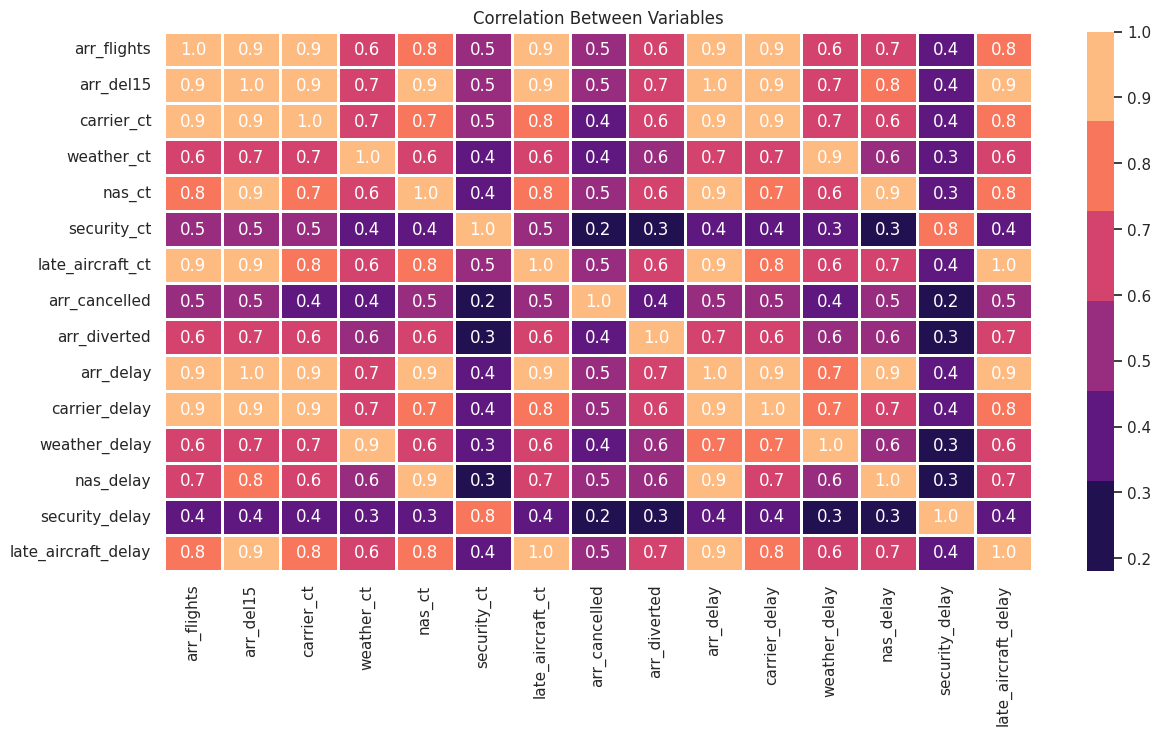

In [124]:
df_corr = df[numeric_columns]
correlation = df_corr.corr()
sns.set(font_scale=1.0)
fig, ax = plt.subplots(figsize=(14, 7))

corr_heatmap = sns.heatmap(correlation, cmap=sns.color_palette("magma"),
                           linewidth=1, edgecolor="k", annot=False, ax=ax)

for i in range(correlation.shape[0]):
    for j in range(correlation.shape[1]):
        ax.text(j + 0.5, i + 0.5, f"{correlation.iloc[i, j]:.1f}",
                ha='center', va='center', color='white')

plt.title("Correlation Between Variables")
plt.show()

# **Delay Level Prediction**

In [125]:
df_delay= df.copy()
df_delay['sum_cancel_diverted']= df_delay['arr_cancelled'] + df_delay['arr_diverted']
df_delay['correct_arr_flights']= df_delay['arr_flights']- df_delay['sum_cancel_diverted']
df_delay['avg_arr_delay'] = df_delay['arr_delay'] / df_delay['correct_arr_flights']

df_delay['delay_level'] = df_delay['avg_arr_delay'].apply(delay_type)
df_delay= df_delay.dropna()
print('Min Delay:', df_delay["avg_arr_delay"].min(),  '      Max Delay:', df_delay["avg_arr_delay"].max())

Min Delay: 0.0       Max Delay: 334.0


In [126]:
pal = sns.color_palette()

df_delay["delay_group"] = None
df_delay.loc[ (df_delay["avg_arr_delay"] >= 0) & (df_delay["avg_arr_delay"] < 15) , "delay_group"] = "on_time"
df_delay.loc[ (df_delay["avg_arr_delay"] >= 15) & ( df_delay["avg_arr_delay"] < 40), "delay_group"] = "small_delay"
df_delay.loc[ (df_delay["avg_arr_delay"] >= 40), "delay_group"] = "large_delay"

df_airline_delay_agg = df_delay.groupby(["month"])["delay_group"].value_counts(normalize=True).unstack()
col_order = ["on_time", "small_delay", "large_delay"]

df_airline_delay_agg[col_order].style.background_gradient(cmap="Purples")

delay_group,on_time,small_delay,large_delay
month,,,
1,0.706763,0.281797,0.011440
2,0.692971,0.298581,0.008449
3,0.741216,0.252872,0.005912
4,0.775750,0.217769,0.006480
5,0.749235,0.248045,0.002720
6,0.545062,0.439278,0.015660
7,0.537067,0.451220,0.011714
8,0.664907,0.328375,0.006718
9,0.881682,0.114625,0.003692


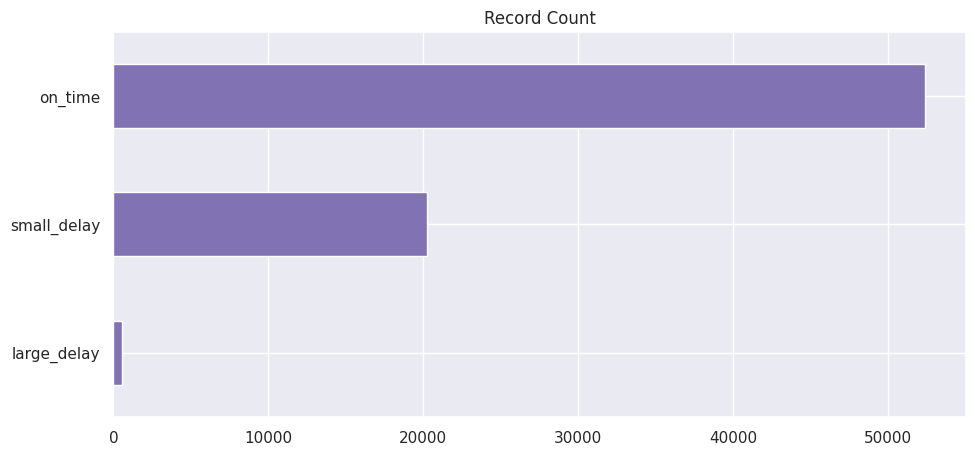

In [127]:
df_delay["delay_group"].value_counts(ascending=True).plot( kind="barh", figsize=(11, 5), color=pal[4], title="Record Count")
plt.show()

In [128]:
df_delay.drop( columns= ['arr_cancelled', 'arr_diverted' ,'arr_delay', 'avg_arr_delay',  'delay_group'], inplace= True)

In [129]:
df_delay["carrier"] = df_delay["carrier"].astype('category')
df_delay["airport"] = df_delay["airport"].astype('category')
df_delay["month"] = df_delay["month"].astype('category')

df_delay["carrier"] = df_delay["carrier"].cat.codes
df_delay["airport"] = df_delay["airport"].cat.codes
df_delay["month"] = df_delay["month"].cat.codes

feature_set = ['month', 'carrier', 'airport', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
    'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay' ,'delay_level']

df_delay= df_delay[feature_set]

df_delay.head(8)

,month,carrier,airport,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,delay_level
0,10,3,4,1.99,0.00,9.01,0.0,0.00,65.0,0.0,201.0,0.0,0.0,0
1,10,3,5,3.47,0.00,1.53,0.0,0.00,57.0,0.0,24.0,0.0,0.0,0
2,10,3,6,1.28,0.69,4.04,0.0,0.00,64.0,11.0,101.0,0.0,0.0,0
3,10,3,8,0.24,0.00,9.21,0.0,0.56,8.0,0.0,526.0,0.0,19.0,0
4,10,3,10,1.34,1.46,15.20,0.0,0.00,85.0,89.0,373.0,0.0,0.0,0
5,10,3,12,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0
6,10,3,14,10.39,0.00,4.45,0.0,5.16,721.0,0.0,113.0,0.0,144.0,0
7,10,3,15,11.64,0.00,23.42,1.0,0.95,450.0,0.0,542.0,35.0,72.0,0


In [130]:
X = df_delay[feature_set[:-1]]
y = df_delay['delay_level']

X_scaled= MinMaxScaler().fit_transform(X)  #MinMaxScaler  StandardScaler

print(X_scaled.shape, y.shape)

(73198, 13) (73198,)


In [131]:
def precision_scorer(estimator, x, y):
    yPred = estimator.predict(x)
    return    precision_score(y, yPred, average='micro')


def recall_scorer(estimator, x, y):
    yPred = estimator.predict(x)
    return    recall_score(y, yPred, average='micro')

def sensitivity_scorer(estimator, x, y):
    yPred = estimator.predict(x)
    return    sensitivity_score(y, yPred, average='micro')

def evaluate_model(X, y, model):

   cval = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
   acc_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cval, n_jobs=-1)
   f_scores= cross_val_score(model, X, y, scoring='f1_micro', cv=cval, n_jobs=-1)
   rec_scores= cross_val_score(model, X, y, scoring= recall_scorer, cv=cval, n_jobs=-1)
   pre_scores= cross_val_score(model, X, y, scoring= precision_scorer, cv=cval, n_jobs=-1)
   sens_scores= cross_val_score(model, X, y, scoring= sensitivity_scorer, cv=cval, n_jobs=-1)

   return acc_scores,f_scores, rec_scores, pre_scores, sens_scores


def clf_models():

    models, names = list(), list()

    models.append(DummyClassifier(strategy='uniform'))
    names.append('DuM')

    models.append(LogisticRegression(C= 0.1))
    names.append('LoR ')

    models.append(DecisionTreeClassifier())
    names.append('DT ')

    models.append(GaussianNB())
    names.append('NB ')

    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')

    models.append(KNeighborsClassifier())
    names.append('KNN')

    models.append(RandomForestClassifier(max_depth=3, random_state=0) )
    names.append('RNDF')


    return models, names


models, names = clf_models()

acc_collect=[]

for i in range(len(names)):
   steps = [ ('o', SMOTE(k_neighbors=2)), ('m', models[i])]
   pipeline = Pipeline(steps=steps)
   acc_vals ,f_vals, rec_vals, pre_vals , sens_vals= evaluate_model(X_scaled ,y, pipeline)

   print('====> %s  Accuracy: %.4f (std %.4f)   Precision: %.4f    Recall: %.4f    F1: %.4f   Sensitivity: %.4f' %
         (names[i], np.mean(acc_vals), np.std(acc_vals), np.mean(pre_vals), np.mean(rec_vals), np.mean(f_vals), np.mean(sens_vals)))

   acc_collect.append(list(acc_vals))

====> DuM  Accuracy: 0.3324 (std 0.0033)   Precision: 0.3373    Recall: 0.3326    F1: 0.3345   Sensitivity: 0.3313
====> LoR   Accuracy: 0.4522 (std 0.0172)   Precision: 0.4551    Recall: 0.4555    F1: 0.4560   Sensitivity: 0.4561
====> DT   Accuracy: 0.7193 (std 0.0040)   Precision: 0.7194    Recall: 0.7187    F1: 0.7199   Sensitivity: 0.7205
====> NB   Accuracy: 0.1196 (std 0.0037)   Precision: 0.1203    Recall: 0.1203    F1: 0.1210   Sensitivity: 0.1205
====> LDA  Accuracy: 0.5190 (std 0.0091)   Precision: 0.5149    Recall: 0.5163    F1: 0.5205   Sensitivity: 0.5163
====> KNN  Accuracy: 0.7454 (std 0.0029)   Precision: 0.7450    Recall: 0.7442    F1: 0.7451   Sensitivity: 0.7450
====> RNDF  Accuracy: 0.4218 (std 0.0129)   Precision: 0.4266    Recall: 0.4232    F1: 0.4234   Sensitivity: 0.4234


- Accuracy is the proprtion of correct predictions to the total predictions:

            Accuracy = (TP + TN)/ (TP + TN + FP + FN)


- Precision summarizes the fraction of examples assigned the positive class that belong to the positive class:

            Precision = TP / (TP + FP)

-  Recall summarizes how well the positive class was predicted:

            Recall = TP/ (TP + FN)

-  F-Measure and Sensitivty consider the false classified items in the negative class. In an imbalanced setting, the low FN indicates that the classifier predicts the majority of the nagative points correctly. That means the the true negative rate is also high.  

           F-Measure = TP / (TP + 1/2 (FP + FN))

           Sensitivity = TP / (TP + FN)

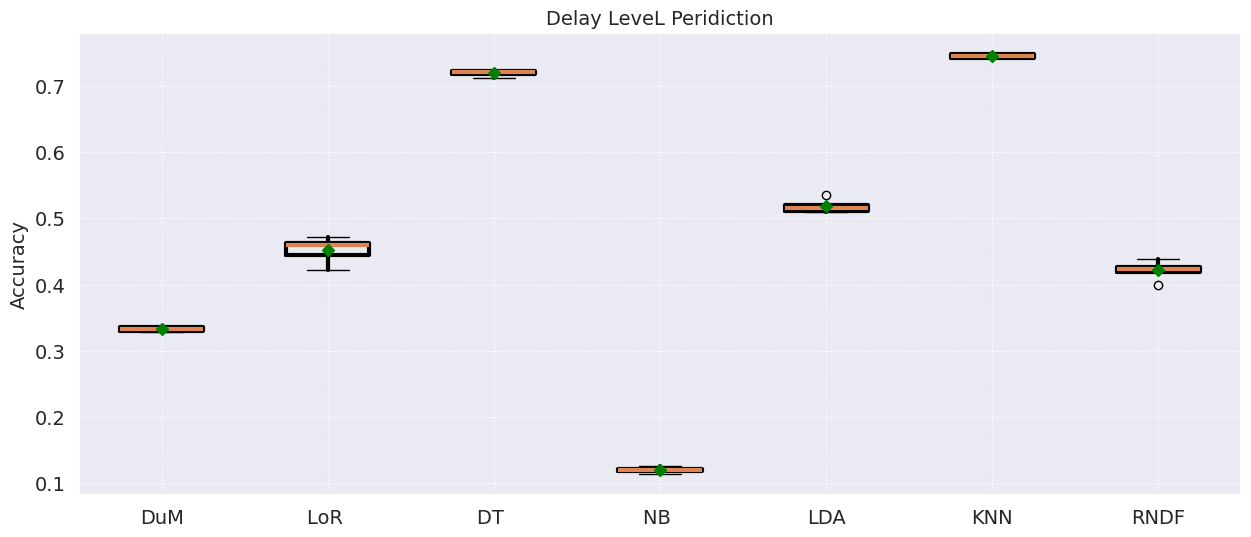

In [132]:
fig = plt.figure()
fig.set_size_inches(15, 6)
plt.ylabel('Accuracy', fontsize=14)
medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
flierprops = dict(marker='o', markerfacecolor='green', markersize=12,
                  linestyle='none')
whiskerprops = dict(linewidth=3, color='black')
meanpointprops = dict(marker='D', markeredgecolor='green',
                      markerfacecolor='green')

plt.boxplot(acc_collect ,labels= names, showmeans=True, whiskerprops=whiskerprops, boxprops=whiskerprops,
                                                       meanprops=meanpointprops,  medianprops={"linewidth": 3,  "solid_capstyle": "butt"})

plt.grid(visible=True, linestyle=':')
plt.tick_params(axis='both',labelsize=14)
plt.title('Delay LeveL Peridiction', fontsize=14)
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

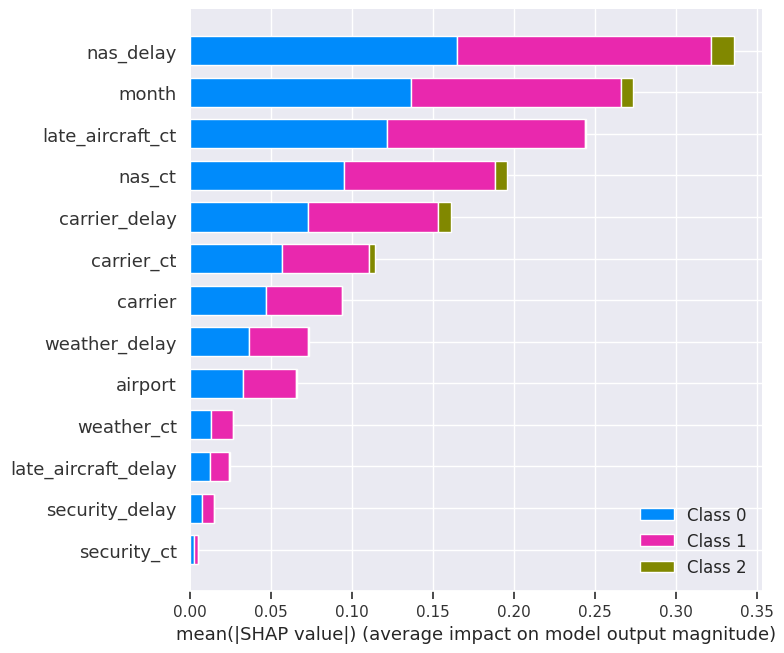

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X[:1000], y[:1000], test_size=0.2, random_state=0)

X_test_summary = shap.kmeans(X_test, 50)
dtree = sklearn.tree.DecisionTreeClassifier(min_samples_split=2)
dtree.fit(X_train, y_train)
explainer = shap.KernelExplainer(dtree.predict_proba,  X_test_summary)
shap_values = explainer.shap_values(X_test)
shap.initjs()
shap.summary_plot(shap_values, X_test)

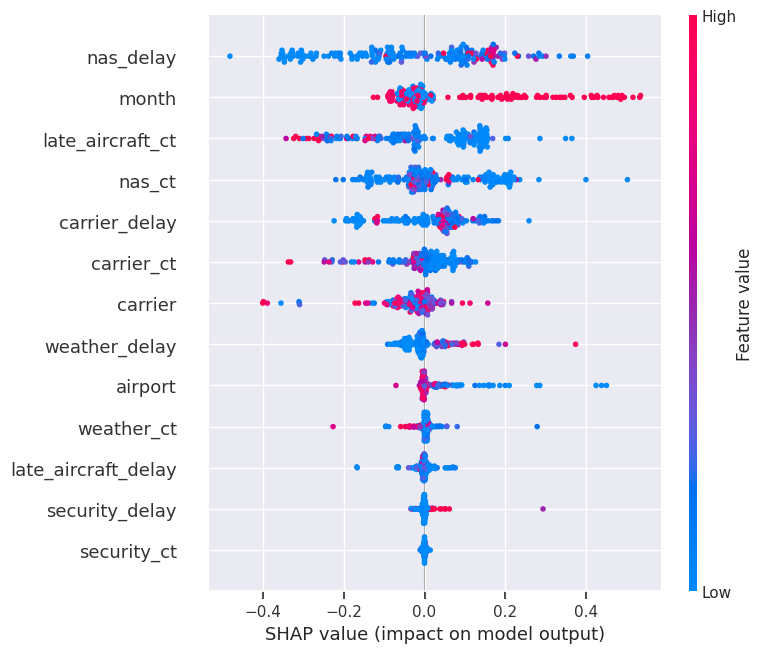

In [134]:
shap.summary_plot(shap_values[1], X_test)

# **Predicting Number of Late Flights**

In [135]:
df_reg= df.copy()
df_reg['sum_cancel_diverted']= df_reg['arr_cancelled'] + df_reg['arr_diverted']
df_reg['correct_arr_flights']= df_reg['arr_flights']- df_reg['sum_cancel_diverted']
df_reg['avg_arr_delay'] = df_reg['arr_delay'] / df_reg['correct_arr_flights']
df_reg=df_reg.dropna()

In [136]:
df_reg["carrier"] = df_reg["carrier"].astype('category')
df_reg["airport"] = df_reg["airport"].astype('category')

df_reg["carrier"] = df_reg["carrier"].cat.codes
df_reg["airport"] = df_reg["airport"].cat.codes

selected_features = ['month', 'carrier', 'airport', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
    'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'arr_del15']

df_reg= df_reg[selected_features]
df_reg.head(10)

,month,carrier,airport,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,arr_del15
0,11,3,4,1.99,0.00,9.01,0.0,0.00,65.0,0.0,201.0,0.0,0.0,11.0
1,11,3,5,3.47,0.00,1.53,0.0,0.00,57.0,0.0,24.0,0.0,0.0,5.0
2,11,3,6,1.28,0.69,4.04,0.0,0.00,64.0,11.0,101.0,0.0,0.0,6.0
3,11,3,8,0.24,0.00,9.21,0.0,0.56,8.0,0.0,526.0,0.0,19.0,10.0
4,11,3,10,1.34,1.46,15.20,0.0,0.00,85.0,89.0,373.0,0.0,0.0,18.0
5,11,3,12,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
6,11,3,14,10.39,0.00,4.45,0.0,5.16,721.0,0.0,113.0,0.0,144.0,20.0
7,11,3,15,11.64,0.00,23.42,1.0,0.95,450.0,0.0,542.0,35.0,72.0,37.0
8,11,3,17,0.78,0.29,3.93,0.0,0.00,21.0,9.0,74.0,0.0,0.0,5.0
9,11,3,19,0.00,0.00,5.00,0.0,0.00,0.0,0.0,104.0,0.0,0.0,5.0


In [137]:
X_reg = df_reg[selected_features[:-1]]
y_reg = df_reg['arr_del15']

In [138]:
def mae_scorer(estimator, x, y):
    y_pred = estimator.predict(x)
    return    mean_absolute_error(y, y_pred)


def r2_scorer(estimator, x, y):
    y_pred = estimator.predict(x)
    return    r2_score(y, y_pred)

def Root_mean_squared_err(estimator, x, y):
    yPred = estimator.predict(x)
    return    sqrt(mean_squared_error(y, yPred))


def relative_root_mean_squared_error(estimator, x,y) :
    pred = estimator.predict(x)
    num = np.sum(np.square(y - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss

def evaluate_model(X, y, model):

   cval = KFold(n_splits=5, shuffle=True, random_state=42)
   r2_scores = cross_val_score(model, X, y, scoring=r2_scorer, cv=cval, n_jobs=-1)
   mae_scores= cross_val_score(model, X, y, scoring=mae_scorer, cv=cval, n_jobs=-1)
   root_scores= cross_val_score(model, X, y, scoring= Root_mean_squared_err, cv=cval, n_jobs=-1)
   pr_scores= cross_val_score(model, X, y, scoring= relative_root_mean_squared_error, cv=cval, n_jobs=-1)
   return r2_scores, mae_scores , root_scores, pr_scores


def clf_models():

    models, names = list(), list()

    models.append(LinearRegression())
    names.append('LinR ')

    models.append(DecisionTreeRegressor(max_depth=3))
    names.append('DTR')

    models.append(KNeighborsRegressor(n_neighbors=2))
    names.append('KNN')

    models.append(GradientBoostingRegressor(max_depth=3, random_state=0))
    names.append('GBR')

    models.append(RandomForestRegressor(max_depth=3, random_state=0))
    names.append('RNDRG')


    return models, names


models, names = clf_models()

accu_collect=[]

for i in range(len(names)):
   steps = [('m', models[i])]
   pipeline = Pipeline(steps=steps)

   r2_scores, mae_scores , root_scores, pr_scores = evaluate_model(X_reg ,y_reg, pipeline)
   print('====> %s MAE: %.4f   RMSE: %.4f  RRMSE: %.4f    R2: %.4f'       % (names[i],  np.mean(mae_scores), np.mean(root_scores), np.mean(pr_scores), np.mean(r2_scores) ))
   accu_collect.append(list(mae_scores))

====> LinR  MAE: 0.0029   RMSE: 0.0063  RRMSE: 0.0000    R2: 1.0000
====> DTR MAE: 58.9009   RMSE: 117.3412  RRMSE: 0.2984    R2: 0.8953
====> KNN MAE: 33.2283   RMSE: 84.1166  RRMSE: 0.2077    R2: 0.9461
====> GBR MAE: 7.3325   RMSE: 18.6052  RRMSE: 0.0455    R2: 0.9974
====> RNDRG MAE: 51.5091   RMSE: 104.4939  RRMSE: 0.2688    R2: 0.9168


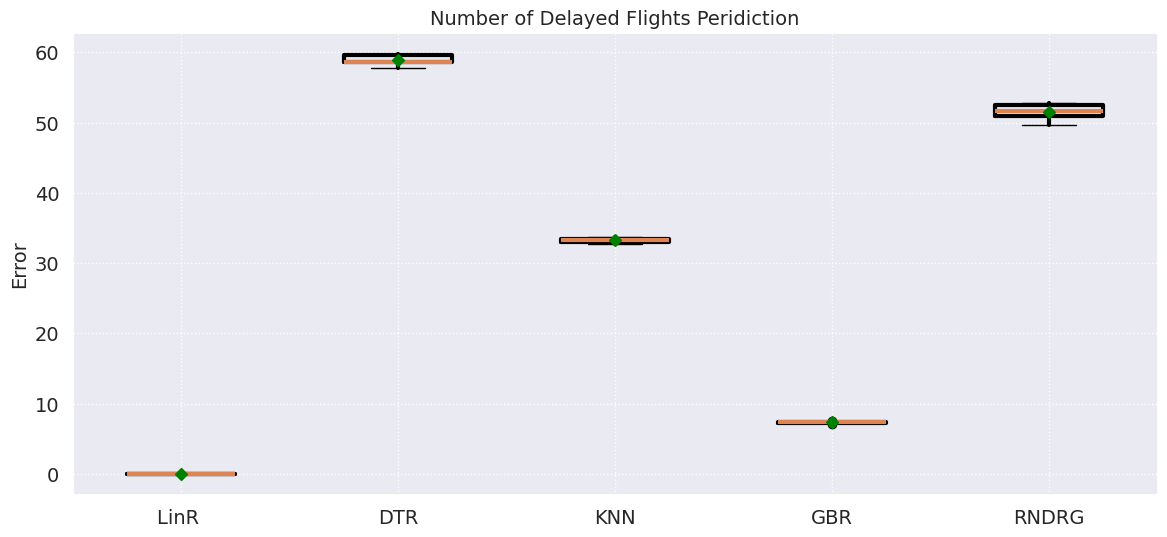

In [139]:
fig = plt.figure()
fig.set_size_inches(14, 6)
plt.ylabel('Error', fontsize=14)
medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
flierprops = dict(marker='o', markerfacecolor='green', markersize=12,
                  linestyle='none')
whiskerprops = dict(linewidth=3, color='black')
meanpointprops = dict(marker='D', markeredgecolor='green',
                      markerfacecolor='green')

plt.boxplot(accu_collect ,labels= names, showmeans=True, whiskerprops=whiskerprops, boxprops=whiskerprops,
                                                       meanprops=meanpointprops,  medianprops={"linewidth": 3,  "solid_capstyle": "butt"})

plt.grid(visible=True, linestyle=':')
plt.tick_params(axis='both',labelsize=14)
plt.title('Number of Delayed Flights Peridiction', fontsize=14)
plt.show()

#**Monthly Delayed Flights Prediction**

In [140]:
df_tr= df.copy()

df_tr['avg_arr_delay'] = df_tr['arr_delay'] / df_tr['arr_flights']
df_tr["month"] = df_tr["month"].astype(str)
df_tr["year"] = df_tr["year"].astype(str)
df_tr['date'] = df_tr[['year', 'month']].agg('-'.join, axis=1)
df_tr['date'] = pd.to_datetime(df_tr['date'])
df_tr.drop( columns= ['arr_cancelled', 'arr_diverted'], inplace= True)

df_del= df_tr[df_tr['carrier_name'] == 'Alaska Airlines Inc.']
df_del.head(8)

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,avg_arr_delay,date
0,2009,11,AS,Alaska Airlines Inc.,DCA,"Washington, DC: Ronald Reagan Washington National",88.0,11.0,1.99,0.00,...,0.0,0.00,266.0,65.0,0.0,201.0,0.0,0.0,3.022727,2009-11-01
1,2009,11,AS,Alaska Airlines Inc.,DEN,"Denver, CO: Denver International",123.0,5.0,3.47,0.00,...,0.0,0.00,81.0,57.0,0.0,24.0,0.0,0.0,0.658537,2009-11-01
2,2009,11,AS,Alaska Airlines Inc.,DFW,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...",66.0,6.0,1.28,0.69,...,0.0,0.00,176.0,64.0,11.0,101.0,0.0,0.0,2.666667,2009-11-01
3,2009,11,AS,Alaska Airlines Inc.,EWR,"Newark, NJ: Newark Liberty International",59.0,10.0,0.24,0.00,...,0.0,0.56,553.0,8.0,0.0,526.0,0.0,19.0,9.372881,2009-11-01
4,2009,11,AS,Alaska Airlines Inc.,HNL,"Honolulu, HI: Daniel K Inouye International",85.0,18.0,1.34,1.46,...,0.0,0.00,547.0,85.0,89.0,373.0,0.0,0.0,6.435294,2009-11-01
5,2009,11,AS,Alaska Airlines Inc.,IAH,"Houston, TX: George Bush Intercontinental/Houston",30.0,0.0,0.00,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2009-11-01
6,2009,11,AS,Alaska Airlines Inc.,LAS,"Las Vegas, NV: McCarran International",283.0,20.0,10.39,0.00,...,0.0,5.16,978.0,721.0,0.0,113.0,0.0,144.0,3.455830,2009-11-01
7,2009,11,AS,Alaska Airlines Inc.,LAX,"Los Angeles, CA: Los Angeles International",469.0,37.0,11.64,0.00,...,1.0,0.95,1099.0,450.0,0.0,542.0,35.0,72.0,2.343284,2009-11-01


In [141]:
final_features = [ 'date',  'carrier_ct',   'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
    'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',  'late_aircraft_delay', 'arr_flights','avg_arr_delay', 'arr_del15']

df_g= df_del.groupby([df_del.date]).mean().reset_index()

df_series= df_g[final_features]

df_series

,date,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,arr_flights,avg_arr_delay,arr_del15
0,2003-06-01,27.042667,0.364000,26.050000,2.188667,34.220667,1511.333333,20.066667,760.933333,71.400000,1605.200000,538.933333,8.374102,89.866667
1,2003-07-01,29.665333,1.369333,19.568000,2.091333,39.908667,1606.333333,103.733333,567.333333,49.266667,1951.800000,573.933333,6.911454,92.600000
2,2003-08-01,35.515333,0.976000,29.856667,1.493333,49.825333,1944.466667,47.866667,866.733333,34.200000,2402.466667,572.933333,10.067628,117.666667
3,2003-09-01,17.780667,0.347333,16.368000,0.222000,19.015333,968.933333,17.133333,547.800000,5.400000,984.066667,507.333333,6.501593,53.733333
4,2003-10-01,21.747333,0.303333,34.128667,0.066000,31.954000,1326.533333,11.866667,1121.666667,1.400000,1806.733333,513.000000,7.478084,88.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,2020-08-01,5.958462,0.615769,8.290385,0.106538,3.183077,294.153846,39.961538,228.038462,2.384615,172.346154,255.576923,2.403993,18.153846
207,2020-09-01,5.154800,0.522800,5.460800,0.085600,1.856400,233.840000,24.600000,132.480000,2.600000,116.160000,264.480000,1.555353,13.080000
208,2020-10-01,6.218462,0.360000,8.781923,0.038462,3.216923,384.615385,21.076923,238.269231,1.500000,177.000000,284.961538,2.105167,18.615385
209,2020-11-01,8.003462,0.378462,9.638846,0.053462,5.656923,542.807692,30.346154,256.615385,1.384615,321.846154,286.076923,3.384913,23.730769


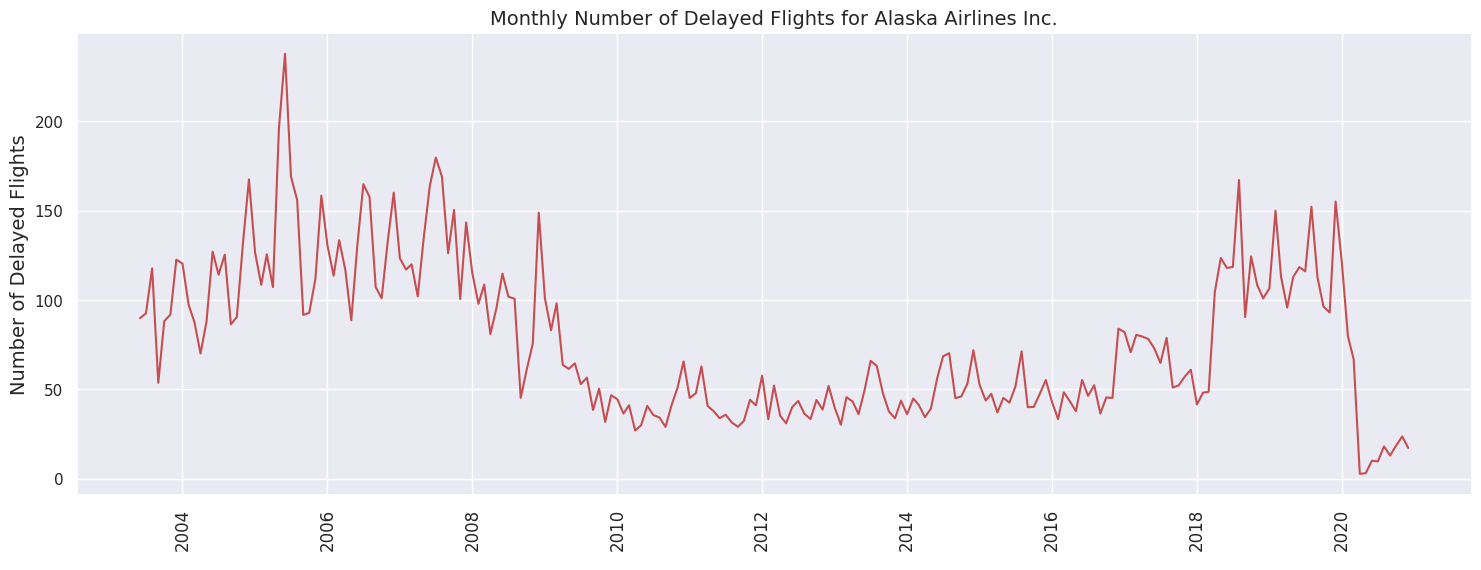

In [142]:
sns.set(font_scale=1.)
sns.set(rc={'figure.figsize':(17, 7)})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
sns.lineplot(data=df_series, x= 'date', y='arr_del15', color = 'r' )
plt.xlabel('  ', fontsize= 3)
plt.ylabel('Number of Delayed Flights', fontsize= 14)
plt.title('Monthly Number of Delayed Flights for Alaska Airlines Inc.', fontsize= 14)
plt.xticks(rotation=90, fontsize=12)
plt.show()

In [143]:
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Input, Dropout
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

def createXY(dataset,n_past):
    dataX = []
    dataY = []

    for i in range(n_past, len(dataset)-1):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i+1, -1])

    return np.array(dataX),np.array(dataY)



series_data=df_series[final_features[1:]].to_numpy()
scaler = StandardScaler()
scaled = scaler.fit_transform(series_data)

X_series,y_series= createXY(scaled, 6)
X_train, X_test, y_train, y_test = train_test_split( X_series, y_series, test_size=0.25, random_state=42)

print('Train:', X_train.shape, y_train.shape)
print('Test:',X_test.shape, y_test.shape)

Train: (153, 6, 13) (153,)
Test: (51, 6, 13) (51,)


In [144]:
grid_model = Sequential()
grid_model.add(LSTM(16,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]) ))
grid_model.add(LSTM(4))
#grid_model.add(Dropout(0.2))
grid_model.add(Dense(1))

grid_model.compile(optimizer = 'adamax', loss = 'mae', metrics=['mae'])
grid_model.fit(X_train,y_train, batch_size=4 ,  epochs=500, verbose=1 )

Epoch 1/500
39/39 [==============================] - 6s 8ms/step - loss: 0.6926 - mae: 0.6926
Epoch 2/500
39/39 [==============================] - 0s 7ms/step - loss: 0.5688 - mae: 0.5688
Epoch 3/500
39/39 [==============================] - 0s 7ms/step - loss: 0.4967 - mae: 0.4967
Epoch 4/500
39/39 [==============================] - 0s 7ms/step - loss: 0.4522 - mae: 0.4522
Epoch 5/500
39/39 [==============================] - 0s 7ms/step - loss: 0.4324 - mae: 0.4324
Epoch 6/500
39/39 [==============================] - 0s 7ms/step - loss: 0.4285 - mae: 0.4285
Epoch 7/500
39/39 [==============================] - 0s 7ms/step - loss: 0.4256 - mae: 0.4256
Epoch 8/500
39/39 [==============================] - 0s 7ms/step - loss: 0.4231 - mae: 0.4231
Epoch 9/500
39/39 [==============================] - 0s 7ms/step - loss: 0.4210 - mae: 0.4210
Epoch 10/500
39/39 [==============================] - 0s 7ms/step - loss: 0.4185 - mae: 0.4185
Epoch 11/500
39/39 [==============================] - 0s 8m

2/2 [==============================] - 1s 8ms/step


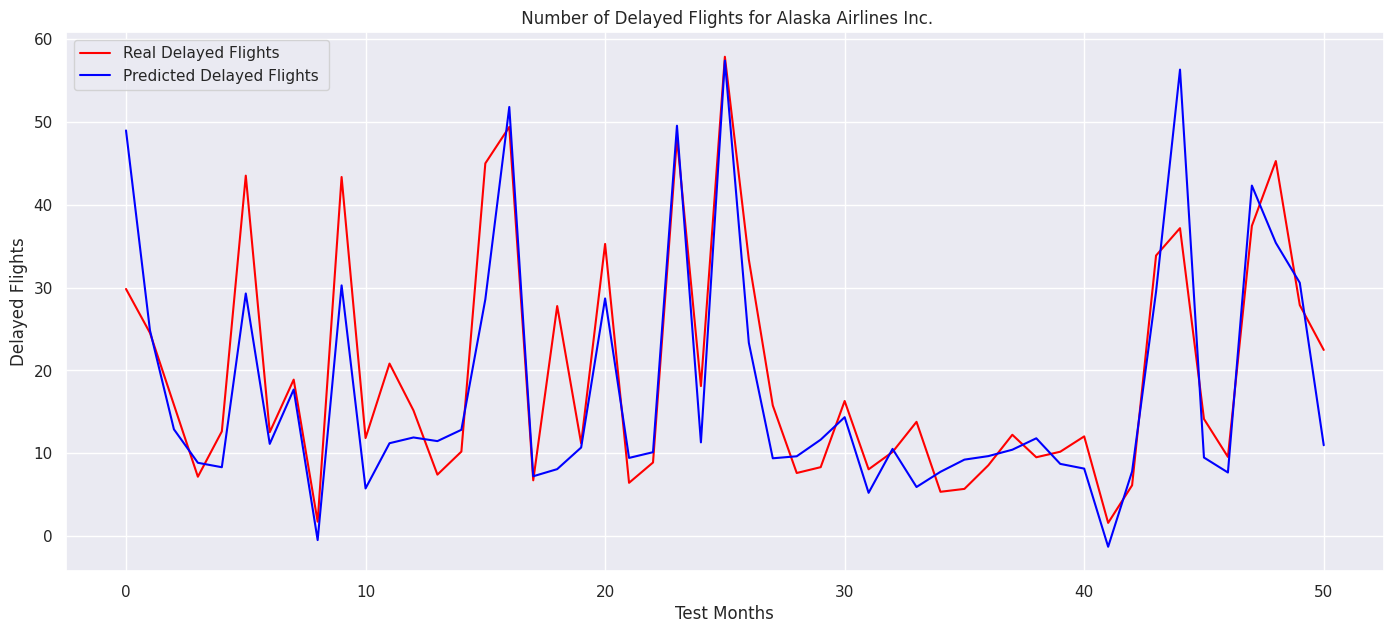

In [145]:
prediction=grid_model.predict(X_test)
prediction_copies_array = np.repeat(prediction,X_train.shape[2], axis=-1)
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),X_train.shape[2])))[:,0]
original_copies_array = np.repeat(y_test,X_train.shape[2] , axis=-1)
original_copies_array.shape

original=scaler.inverse_transform(np.reshape(original_copies_array,(len(y_test),X_train.shape[2])))[:,0]

plt.plot(original, color = 'red', label = 'Real Delayed Flights')
plt.plot(pred, color = 'blue', label = 'Predicted Delayed Flights ')
plt.title(' Number of Delayed Flights for Alaska Airlines Inc.')
plt.ylabel('Delayed Flights')
plt.xlabel('Test Months')
plt.legend()
plt.show()

In [146]:
y_pred = pred
y_test= original


def relative_root_mean_squared_error(y, pred) :
    num = np.sum(np.square(y - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss

rmse=sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, pred)
mape= mean_absolute_percentage_error(y_test, y_pred)
mae= mean_absolute_error(y_test, pred)
rrmse= relative_root_mean_squared_error(y_test, y_pred)

print('MAE: %.4f   RMSE: %.4f     RRMSE: %.4f     R2: %.4f' %(mae, rmse, rrmse, r2))


MAE: 5.1023   RMSE: 7.2339     RRMSE: 0.3144     R2: 0.7481


In [147]:
print('Thanks for Attention!')

Thanks for Attention!
